# Copy Number Pipeline

In [50]:
from __future__ import print_function
import os.path
import numpy as np
import pandas as pd
from IPython.display import Image,display
import dalmatian as dm
from IPython.core.display import HTML 
from src.CCLE_postp_function import *
import sys
sys.path.insert(0, '../JKBio/')
import TerraFunction as terra
import rpy2
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
from taigapy import TaigaClient
tc = TaigaClient()
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## boot up

- you first need to go to [taiga](https://cds.team/taiga/dataset) and create some new datasets for the virtual release

we are instanciating all the parameters needed for this pipeline to run

In [51]:
samplesetname = "20Q1"
releAse="20q1"
prevname = '19Q4'
prevprevname ='19Q3'
prevversion='38'
prevprevversion='33'
virtual_public='public-20q1-c3b6'
virtual_dmc='dmc-20q1-c1d7'
virtual_internal='internal-20q1-f1a0'

workspace1="broad-genomics-delivery/Getz_IBM_CellLines_Exomes"
workspace2="broad-firecloud-ccle/CCLE_DepMap_WES"
workspace3="broad-genomics-delivery/CCLE_DepMap_WES"
refworkspace="broad-firecloud-ccle/DepMap_WES_CN_hg38"
source1="ibm"
source2="ccle"
source3="ccle"
release = samplesetname
sheeturl = "https://docs.google.com/spreadsheets/d/115TUgA1t_mD32SnWAGpW9OKmJ2W5WYAOs3SuSdedpX4"

In [52]:
%%R
release <- '20Q1'
prevname <- '19Q4'
version<-37
genome_version <- 'hg38'

In [53]:
wm1 = dm.WorkspaceManager(workspace1)
wm2 = dm.WorkspaceManager(workspace2)
wm3 = dm.WorkspaceManager(workspace3)

refwm = dm.WorkspaceManager(refworkspace)

In [5]:
extract_to_change = {'ref_bams':'WES_bam'}

## Adding new data

We are looking for new samples in a range of workspaces.

They are quite messy and might contains duplicates, contain broken file paths...

- We are thus looking at the bam files one by one and comparing them with our own bams. 
- We remove broken files, duplicates and add new version of a cell line's bam if we find some.

In [27]:
sample_ids, refsamples, ccle_name = createDatasetWithNewCellLines(refworkspace, samplesetname, wmfroms = [workspace1, workspace2, workspace3], sources=[source1, source2, source3], gsfolderto='gs://ccle_bams/wes/', match='ACH', participantslicepos=10, accept_unknowntypes=True, extract = extract_to_change, dry_run = True)

you need to have installed JKBio in the same folder as ccle_processing
Getting sample infos...

The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/Getz_IBM_CellLines_Exomes>: (102, 232)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
Len of samples before removal: 102
These bam file path do not exist: set()
Dups from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/Getz_IBM_CellLines_Exomes> has len 102:
 ['gs://fc-11136d2a-c57a-4e95-ac0e-ff6850e8db54/Getz_IBM_CellLines_Exomes_6samples_04282018/RP-1561/Exome/UMUC13/v3/UMUC13.bam', 'gs://fc-11136d2a-c57a-4e95-ac0e-ff6850e8db54/Getz_IBM_CellLine_WES_June2019/RP-1561/Exome/HHUA/v1/HHUA.bam', 'gs://fc-11136d2a-c57a-4e95-ac0e-ff6850e8db54/Getz_IBM_CellLines_Exomes_14samples_10312018/RP-1561/Exome/ICC8/v1/ICC8.bam', 'gs://fc-11136d2a-c57a-4e95-ac


The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_WES>: (17, 224)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
Len of samples before removal: 17
These bam file path do not exist: set()
Dups from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_WES> has len 17:
 ['gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/ICC5/v1/ICC5.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/RCK8/v1/RCK8.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/TGW_1/v1/TGW_1.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/SCC3/v1/SCC3.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exo

/home/jeremie/ccle_processing/src/CCLE_postp_function.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['id']][i] = val + '_' + str(num_in_workspace + 1)


Len of samples before removal: 133
These bam file path do not exist: {'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/DepMap_CellLine_WES_Batch3_June2019/RP-1561/Exome/R256/v1/R256.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/CCLE_DepMap_WES_July_Dec_2018/RP-1561/Exome/UMUC4/v3/UMUC4.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/CCLE_DepMap_WES_July_Dec_2018/RP-1561/Exome/UMUC7/v4/UMUC7.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/CCLE_DepMap_WES_July_Dec_2018/RP-1561/Exome/UMUC6/v3/UMUC6.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/CCLE_DepMap_WES_July_Dec_2018/RP-1561/Exome/H103/v4/H103.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/CCLE_DepMap_WES_July_Dec_2018/RP-1561/Exome/UMUC16/v3/UMUC16.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/CCLE_DepMap_WES_July_Dec_2018/RP-1561/Exome/UMUC10/v3/UMUC10.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/CCLE_DepMap_WES_July_Dec_2018/RP-1561/Exome/UMUC11/v3/UMUC11.bam', 'gs://fc-19945ed2-3eca-4a49-a1f2-9

(Pdb) n
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(184)createDatasetWithNewCellLines()
-> if len(sampless) == 0:
(Pdb) n
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(186)createDatasetWithNewCellLines()
-> for ind, val in sampless.iterrows():
(Pdb) n
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(187)createDatasetWithNewCellLines()
-> name = val[extract['id']]
(Pdb) n
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(188)createDatasetWithNewCellLines()
-> if name in rename.keys():
(Pdb) val[extract['id']]
'ACH-002065_2'
(Pdb) n
> /home/jeremie/ccle_processing/src/CCLE_postp_function.py(190)createDatasetWithNewCellLines()
-> refsamples = refsamples.append(pd.Series(
(Pdb) val[extract['bam']]
'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/DepMap_CellLine_WES_Nov2019/RP-1561/Exome/HSPSS/v2/HSPSS.bam'
(Pdb) val[extract['bai']]
'gs://fc-19945ed2-3eca-4a49-a1f2-9bf13d07d011/DepMap_CellLine_WES_Nov2019/RP-1561/Exome/HSPSS/v2/HSPSS.bai'
(Pdb) gs

BdbQuit: 

In [16]:
newsample[1][newsample[1].index.isin(newsample[0])]

NameError: name 'newsample' is not defined

In [8]:
#temporary renaming
rename = {'ACH-002446_2':'ACH-003000_1'}

you need to have installed JKBio in the same folder as ccle_processing


In [9]:
sample_ids, refsamples, ccle_name = createDatasetWithNewCellLines(refworkspace, samplesetname, wmfroms = [workspace1, workspace2, workspace3], sources=[source1, source2, source3], gsfolderto='gs://ccle_bams/wes/', match='ACH', participantslicepos=10, accept_unknowntypes=True, extract = extract_to_change, dry_run = False, rename=rename)

Getting sample infos...

The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/Getz_IBM_CellLines_Exomes>: (102, 232)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
Len of samples before removal: 102
These bam file path do not exist: set()
Dups from <dalmatian.wmanager.WorkspaceManager broad-genomics-delivery/Getz_IBM_CellLines_Exomes> has len 101:
 ['gs://fc-11136d2a-c57a-4e95-ac0e-ff6850e8db54/Getz_IBM_CellLines_Exomes_6samples_04282018/RP-1561/Exome/UMUC13/v3/UMUC13.bam', 'gs://fc-11136d2a-c57a-4e95-ac0e-ff6850e8db54/Getz_IBM_CellLine_WES_June2019/RP-1561/Exome/HHUA/v1/HHUA.bam', 'gs://fc-11136d2a-c57a-4e95-ac0e-ff6850e8db54/Getz_IBM_CellLines_Exomes_14samples_10312018/RP-1561/Exome/ICC8/v1/ICC8.bam', 'gs://fc-11136d2a-c57a-4e95-ac0e-ff6850e8db54/Getz_IBM_CellLines_Exomes_14samples_10312018/RP-1561/Ex


The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_WES>: (17, 224)
Identifying any true duplicates by checking file sizes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
Len of samples before removal: 17
These bam file path do not exist: set()
Dups from <dalmatian.wmanager.WorkspaceManager broad-firecloud-ccle/CCLE_DepMap_WES> has len 17:
 ['gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/ICC5/v1/ICC5.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/RCK8/v1/RCK8.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/TGW_1/v1/TGW_1.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exome/SCC3/v1/SCC3.bam', 'gs://fc-b083f84c-98f2-4b0c-bdb2-cdffd601ee6c/DepMap_CellLine_WES_Feb2019/RP-1561/Exo

                                       sample_id rna_ribosomal_bases  \
0                RP-1561_WERIRB1_v2_Exome_OnPrem                null   
0  RP-1561_CCLFUPGI0005T-311Cas9_v2_Exome_OnPrem                null   
1                  RP-1561_HSPSS_v2_Exome_OnPrem                null   
2                   RP-1561_ICC7_v1_Exome_OnPrem                null   
3             RP-1561_KARPAS1718_v2_Exome_OnPrem                null   
4                 RP-1561_MOLM14_v2_Exome_OnPrem                null   
5                  RP-1561_OSC19_v2_Exome_OnPrem                null   
6                  RP-1561_RMSYM_v1_Exome_OnPrem                null   
7                   RP-1561_T3M3_v1_Exome_OnPrem                null   
8                  RP-1561_U2940_v1_Exome_OnPrem                null   

  wgs_pct_80x hs_zero_cvg_targets_pct min_insert_size  \
0           0                 .019007               2   
0           0                 .018823               2   
1           0                  .0189

In [24]:
refsamples[refsamples.index.isin(sample_ids)].WES_bam

sample_id
ACH-001421_2                  gs://ccle_bams/wes/WERIRB1.bam
ACH-003000      gs://ccle_bams/wes/CCLFUPGI0005T-311Cas9.bam
ACH-002065_1                    gs://ccle_bams/wes/HSPSS.bam
ACH-001847_1                     gs://ccle_bams/wes/ICC7.bam
ACH-001533_1               gs://ccle_bams/wes/KARPAS1718.bam
ACH-001574_1                   gs://ccle_bams/wes/MOLM14.bam
ACH-001625_2                    gs://ccle_bams/wes/OSC19.bam
ACH-002048_1                    gs://ccle_bams/wes/RMSYM.bam
ACH-002021_1                     gs://ccle_bams/wes/T3M3.bam
ACH-001678_1                    gs://ccle_bams/wes/U2940.bam
Name: WES_bam, dtype: object

## Check that we have all the cell lines we expect for this release

This involves comparing to the list in the Google sheet "Cell Line Profiling Status."

_As the list cannot be parsed, we are not comparing it for now_

In [ ]:
# this function may not work - it hasn't been tested
url = 'https://docs.google.com/spreadsheets/d/1qus-9TKzqzwUMNWp8S1QP4s4-3SsMo2vuQRZrNXf7ag/edit?ts=5db85e27#gid=0&fvid=1627883727'

compareToCuratedGS(url, sample = newsample[0], samplesetname = samplesetname, colname = 'CN New to internal')

# run Terra pipeline

We are using Dalmatian to send request to Terra, we are running a set of 5 functions To generate the copy number dataset:

*   **BamToUnmappedRGBams_MC** vdauwera/BamToUnmappedRGBamsSnapshot ID: 3
*   **Generate_uBAM_File_List** gkugener/ArrayOfFilesToTxtSnapshot ID: 1
*   **Realign_WES_GATK4** gatk/PreProcessingForVariantDiscovery_GATK4Snapshot ID: 7
*   **CNV_sample_XX** gatk/CNV_Somatic_Pair_WorkflowSnapshot ID: 9
*   **Aggregate_CN_seg_files** gkugener/Aggregate_CN_seg_filesSnapshot ID: 2

This output file for download will be saved under the sample set under the combined_seg_file attribute.

There are several other tasks in this workspace. In brief:

*   **CNV_Somatic_Panel_Workflow_Agilent_XX** gatk/CNV_Somatic_Panel_WorkflowSnapshot ID: 11. This task was used in this workspace to generate the Sanger PON. In the Sanger dataset, there is a set of 40 normal cell lines samples (cell lines derived from matched normal tissue). We can use these to generate a PON to normalize to rather than using the Agilent PON we use for the other CCLE cell lines. This leads to less noisy results. HOWEVER, results using the PON from this workflow should not use the X chromosome, as the sanger normals are not exclusively female or male (it is likely a mix).
*   **SANGER_PON_CNV_sample_XX** gatk/CNV_Somatic_Pair_WorkflowSnapshot ID: 9. Same as the CNV_sample_XX_gatk, except that is uses the Sanger based PON. Should be used only for the Sanger cell lines.
*   **Sanger_PON_Aggregate_CN_seg_files** gkugener/Aggregate_CN_seg_filesSnapshot ID: 2. Aggregates the segment files for the samples that were run using the Sanger PON based CNV workflow.

## On Terra

In [5]:
bamtoubam= "BamToUnmappedRGBams_MC"
ubamtofilelist = "Generate_uBAM_File_List"
realign="Realign_WES_GATK4"

In [31]:
subid = refwm.create_submission(bamtoubam,samplesetname,"sample_set","this.samples")
terra.waitForSubmission(refworkspace, subid)

Successfully created submission 6de5dbf8-f724-4ebf-989d-3d9d49f97eb8.
1.0 of jobs Succeeded in submission 0.sion 0. 175 mn elapsed..


[]

In [32]:
subid = refwm.create_submission(ubamtofilelist,samplesetname,"sample_set","this.samples")
terra.waitForSubmission(refworkspace, subid)

you need to have installed JKBio in the same folder as ccle_processing
Successfully created submission bb853f69-84bb-49ac-932c-d928b2ee1724.
1.0 of jobs Succeeded in submission 0.sion 0. 6 mn elapsed.


[]

In [6]:
subid = refwm.create_submission(realign,samplesetname,"sample_set","this.samples")
terra.waitForSubmission(refworkspace, subid)

KeyboardInterrupt: 

In [8]:
submission_id= refwm.create_submission("CNV_sample_XX",etype='sample_set',entity=samplesetname,expression='this.samples')
terra.waitForSubmission(refworkspace,submission_id)

Successfully created submission 607fabda-c8f6-4e12-a48a-c131948074e1.
ACH-001625_2
0.9090909090909091 of jobs Succeeded in submission 0.lapsed.


RuntimeError: 1 failed submission

In [9]:
submission_id = refwm.create_submission("Aggregate_CN_seg_files",entity=samplesetname)
terra.waitForSubmission(refworkspace,submission_id)

Successfully created submission 48319439-3390-41a2-a0d0-be05505e40cd.
1.0 of jobs Succeeded in submission 0.sion 0. 5 mn elapsed.


[]

In [10]:
aggregated = refwm.get_entities('sample_set').loc[samplesetname]["combined_seg_file"]
aggregated

'gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/48319439-3390-41a2-a0d0-be05505e40cd/aggregate_CN_segments_wrkflw/5512fea1-4039-4ae9-b78d-b237fe118c37/call-aggregate_CN_segments/20Q1.called.seg'

## On local

__We then save the workflow configurations used__

In [12]:
terra.saveConfigs(refworkspace,'data/'+samplesetname+'/CNVconfig')

__,delete unmapped bams generated during the process__

In [54]:
sam = refwm.get_samples()
samplesinset = sam[sam.index.isin(refwm.get_sample_sets().loc[samplesetname].samples)]

In [55]:
for val in samplesinset.readgroup_ubams:
    ubams = ''
    for v in val:
        ubams+=' '+v
    os.system('gsutil -m rm'+ubams)

__and move the hg38 aligned bams to our own datastorage bucket__

In [56]:
onlycol = ['hg38_analysis_ready_bam',
'hg38_analysis_ready_bam_index',
'hg38_analysis_ready_bam_md5']
newgs = 'gs://ccle_bams/hg38_wes/'
for k, val in samplesinset[onlycol].iterrows():
    data = ''
    for v in val:
        data+=' '+v
    ! gsutil -m mv $data $newgs
terra.changeGSlocation(refworkspace,prevgslist=['gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/'], newgs=newgs, onlycol=onlycol, entity='samples',keeppath=False)

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/68180762-335b-487b-82c9-f77d92363615/call-GatherBamFiles/ACH-001421_2.hg38.bam [Content-Type=application/octet-stream]...
Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/68180762-335b-487b-82c9-f77d92363615/call-GatherBamFiles/ACH-001421_2.hg38.bai [Content-Type=application/octet-stream]...
Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/68180762-335b-487b-82c9-f77d92363615/call-GatherBamFiles/ACH-001421_2.hg38.bam.md5 [Content-Type=application/octet-stream]...
Removing gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/68180762-335b-487b-82c9-f77d92363615/call-GatherBamFiles/ACH-001421_2.hg38.bai...
Rem

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/79bba88f-baec-4af5-91a6-41693aa4f1e4/call-GatherBamFiles/ACH-001847_1.hg38.bai [Content-Type=application/octet-stream]...
Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/79bba88f-baec-4af5-91a6-41693aa4f1e4/call-GatherBamFiles/ACH-001847_1.hg38.bam.md5 [Content-Type=application/octet-stream]...
Removing gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/79bba88f-baec-4af5-91a6-41693aa4f1e4/call-GatherBamFiles/ACH-001847_1.hg38.bai...
Removing gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/256ac31f-0de1-4984-a2d2-e08af03f3d15/PreProcessingForVariantDiscovery_GATK4/79bba88f-baec-4af5-91a6-41693aa4f1e4/call-GatherBamFiles/ACH-001847_1.hg38.bam.md5...
Removing gs://fc-secure-d2a2d895-a7af-

NameError: name 'changeGSlocation' is not defined

In [13]:
! gsutil cp $aggregated "temp/cnv_ccle.called.seg"

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/48319439-3390-41a2-a0d0-be05505e40cd/aggregate_CN_segments_wrkflw/5512fea1-4039-4ae9-b78d-b237fe118c37/call-aggregate_CN_segments/20Q1.called.seg...
/ [1 files][115.5 KiB/115.5 KiB]                                                
Operation completed over 1 objects/115.5 KiB.                                    


__We download and reprocess removing the appended version and keeping only the newest versions__

In [14]:
a = pd.read_csv("temp/cnv_ccle.called.seg", sep='\t')
a['Sample'] = [i.split('_')[0] for i in a['Sample']]
a.to_csv("temp/cnv_ccle.called.seg", sep='\t')

__If want to reprocess something__

In [ ]:
#%%R
#segments_unfiltered <- readr::read_csv('temp/wes.19Q3.segmented.cn')

## post Procesing

The post processing happens in R using guillaume's functions, in brief:

- processSegments
- filterForCCLE
- interpolateGapsInSegmented
- extendEndsOfSegments
- reprioritizeData

In [15]:
%%R
source('../gkugener/RScripts/load_libraries_and_annotations.R')
source("src/CCLE_postp_function.R")
library('celllinemapr')
library('magrittr')
library('taigr')
library('cdsomics')
library('readr')

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ stringr 1.4.0
✔ tidyr   1.0.0     ✔ forcats 0.4.0
✔ readr   1.3.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr

R[write to console]: Loading required package: graph

R[write to console]: 
Attaching package: ‘graph’


R[write to console]: The following object is masked from ‘package:XML’:

    addNode


R[write to console]: The following object is masked from ‘package:stringr’:

    boundary


R[write to console]: The following object is masked from ‘package:plyr’:

    join


R[write to console]: Loading required package: RCurl

R[write to console]: Loading required package: bitops

R[write to console]: 
Attaching package: ‘RCurl’


R[write to console]: The following object is masked from ‘package:tidyr’:

    complete


R[write to console]: Loading required package: httr

R[write to console]: 
Attaching package: ‘httr’


R[write to console]: The following object is masked from ‘package:Biobase’:

    content


R[write to console]: The following object is masked from ‘package:plotly’:

    config


R[write to console]: Package 'mclust' version 5.4.5
Type 'citation("mclust")' for citing this R pa

In [30]:
%%R
# Previous release copy number profiles. This line will need to be updated as well
wes.priority.cn.seg.profiles <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.file=paste0("wes.",prevname,".segmented"),data.version='38') %>%
  dplyr::select(DepMap_ID, Chromosome, Start, End, Num_Probes, Segment_Mean, Source)

Fetching https://cds.team/taiga/api/dataset/segmented-cn-wes-prioritzed-7fe1/38 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/segmented-cn-wes-prioritzed-7fe1_38.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/c137b47645854a00b779d965c49edcf7_wes-19q4-segmented.rds



__between 0,1,150: not log2 transformed__

In [31]:
%%R
print(mean(wes.priority.cn.seg.profiles$Segment_Mean))
print(max(wes.priority.cn.seg.profiles$Segment_Mean))
print(min(wes.priority.cn.seg.profiles$Segment_Mean))

[1] 1.068518
[1] 148.1349
[1] 1.927306e-10


In [32]:
%%R
segments <- processSegments("temp/cnv_ccle.called.seg")
segments <- filterForCCLE(segments)
segments <- interpolateGapsInSegmented(segments)$segs
segments <- extendEndsOfSegments(segments,'../JKBio/data/hg38_cytoband.gz')
print(segments)
print(head(wes.priority.cn.seg.profiles))
# reprioritize also undo logtransform
segments_unfiltered <- reprioritizeData(segments, wes.priority.cn.seg.profiles)
# Fill in the gaps on the entire dataset
# Extend start sites to 1, end sites to the end of the chromosome?

[1] 0


R[write to console]: Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character()
)



# A tibble: 2,276 x 7
   DepMap_ID  seqnames     start       end Num_Probes Segment_Mean Source   
   <chr>      <fct>        <dbl>     <dbl>      <dbl>        <dbl> <chr>    
 1 ACH-001421 chr1             1   5325599        716        1.05  Broad WES
 2 ACH-001421 chr1       5325600   5982284         28        0.644 Broad WES
 3 ACH-001421 chr1       5982285 107727015       8541        0.972 Broad WES
 4 ACH-001421 chr1     107727016 111183210        466        1.22  Broad WES
 5 ACH-001421 chr1     111183211 143881254        799        0.967 Broad WES
 6 ACH-001421 chr1     143881255 146549308        156        2.41  Broad WES
 7 ACH-001421 chr1     146549309 149831938        128        3.37  Broad WES
 8 ACH-001421 chr1     149831939 150662780        186        1.91  Broad WES
 9 ACH-001421 chr1     150662781 152461884        384        2.89  Broad WES
10 ACH-001421 chr1     152461885 154234993        294        2.90  Broad WES
# … with 2,266 more rows
   DepMap_ID Chromosome    St

In [34]:
%%R
print(mean(segments_unfiltered$Segment_Mean))
print(max(segments_unfiltered$Segment_Mean))
print(min(segments_unfiltered$Segment_Mean))

[1] 1.068472
[1] 148.1349
[1] 1.927306e-10


In [35]:
%%R
write.table(segments_unfiltered, file = paste0("temp/wes.",release,".segmented.cn"), sep = ',', quote = F, row.names = F) 

### creating gene copy number

- generateEntrezGenes
- generateGeneLevelMatrixFromSegments

In [36]:
%%R
entrezgenes <- generateEntrezGenes()

In [37]:
%%R
head(corner(entrezgenes))

   EGID SYMBOL CHR    CHRLOC CHRLOCEND
1     1   A1BG  19  58346805  58353499
2    10   NAT2   8  18391281  18401215
3   100    ADA  20  44619518  44651758
4  1000   CDH2  18  27950962  28177130
5 10000   AKT3   1 243488232 243843584


In [38]:
%%R
res <- generateGeneLevelMatrixFromSegments(entrezgenes, segments_unfiltered)

In [39]:
%%R
genematrix_unfiltered <- res$gene_level_data_hg38
corner(genematrix_unfiltered)

           A1BG (1) NAT2 (10) ADA (100) CDH2 (1000) AKT3 (10000)
ACH-000001 1.265172 1.1415254 1.2958359   0.6627515     1.012791
ACH-000002 1.013633 0.9741737 1.0175121   1.4893275     1.012618
ACH-000003 1.031898 1.0958118 1.8768326   0.5364814     1.002498
ACH-000004 1.349290 1.0865089 0.7855092   1.0770610     1.086057
ACH-000005 1.222033 1.1622070 0.7612536   1.0724579     1.120937


In [40]:
%%R
print(mean(genematrix_unfiltered))
print(max(genematrix_unfiltered))

[1] 1.0269
[1] 148.1349


In [41]:
%%R
write.table(genematrix_unfiltered, file = paste0('temp/wes.',release,'.gene.cn'), 
sep = ',', quote = F, row.names = T)

## Validation step

Once the files are saved, we load them back in python and do some validations, in brief:

- mean,max,var...
- to previous version: same mean,max,var...
- checkAmountOfSegments: flag any samples with a very high number of segments
- checkGeneChangeAccrossAll: flag any genes which stay at a similar value across all samples

In [45]:
genecn = pd.read_csv('temp/wes.'+release+'.gene.cn', sep = ',')

In [46]:
segmentcn = pd.read_csv('temp/wes.'+release+'.segmented.cn', sep = ',')

In [46]:
prev = set(tc.get(name='segmented-cn-wes-prioritzed-7fe1', file='wes.'+prevname+'.gene', version="38").index.tolist())
prevprev= set(tc.get(name='segmented-cn-wes-prioritzed-7fe1', file='wes.'+prevprevname+'.gene', version='33').index.tolist())

[##################]100% |  31.2 MiB/s | 370.9 MiB / 370.9 MiB | Time:  0:00:11
[##################]100% |  42.0 MiB/s | 363.3 MiB / 363.3 MiB | Time:  0:00:08


In [50]:
new1 = set(genecn.index.values.tolist())
new2 = set(segmentcn['DepMap_ID'].values.tolist())
print(len(prev), len(prev & new1), len(new1), len(new1 & new2))

1752 1752 1760 1760


In [51]:
checkAmountOfSegments(segmentcn,thresh = 750)

ACH-001079 2586
ACH-000044 1202
ACH-000258 872
ACH-001230 947
ACH-000068 812
ACH-000454 1051
ACH-000216 925
ACH-001150 782
ACH-001214 889
ACH-002335 1312
ACH-000836 1001
ACH-001957 1426
ACH-000960 913
ACH-000458 762
ACH-000578 869
ACH-000327 819
ACH-000090 1024
ACH-000488 954
ACH-000848 1171
ACH-000923 1469
ACH-000904 868
ACH-000452 816
ACH-000600 939
ACH-001656 902
ACH-000854 899
ACH-000774 953
ACH-001000 980
ACH-000941 813
ACH-000887 1408
ACH-001017 1223
ACH-001171 792
ACH-001071 1175
ACH-000593 764
ACH-001239 851
ACH-000071 1287
ACH-001956 1368
ACH-000509 873
ACH-002204 1318
ACH-000550 974
ACH-000738 1064
ACH-000870 1557
ACH-001036 858
ACH-001043 825
ACH-000028 868
ACH-001955 1296
ACH-000419 826
ACH-001234 819
ACH-001094 1036
ACH-001225 792
ACH-000118 794
ACH-000300 1431
ACH-001113 1072
ACH-001045 822
ACH-000444 974
ACH-000901 816
ACH-000865 1358
ACH-000961 763
ACH-001249 1756
ACH-000167 838
ACH-001101 1005
ACH-000842 929
ACH-000837 1015
ACH-000710 968
ACH-000195 2029
ACH-000064 120

In [52]:
checkGeneChangeAccrossAll(genecn, thresh=1.5)

array([], dtype=object)

In [53]:
segmentcn.Start = segmentcn.Start.astype(int)
segmentcn.End = segmentcn.End.astype(int)

In [56]:
genecn.values.min(), genecn.values.mean(), genecn.values.max()

(1.927306e-10, 1.0269003222177404, 148.134924260474)

In [ ]:
if(genecn.values.max() > 100):
    print("\n\n\nTOO HIGH, not LOG2 transformed!")
if(len(genecn.index.tolist()) > len(set(genecn.index))):
    print("Duplicate CL, not reprioritized well!")

In [ ]:
segmentcn[segmentcn["DepMap_ID"]=="ACH-000658"]

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/52705548-2864-4069-8d1f-0ba4a89a9565/call-PlotModeledSegmentsTumor/out/ACH-001421_2.hg38.modeled.png...
/ [1 files][532.2 KiB/532.2 KiB]                                                
Operation completed over 1 objects/532.2 KiB.                                    
ACH-001421_2


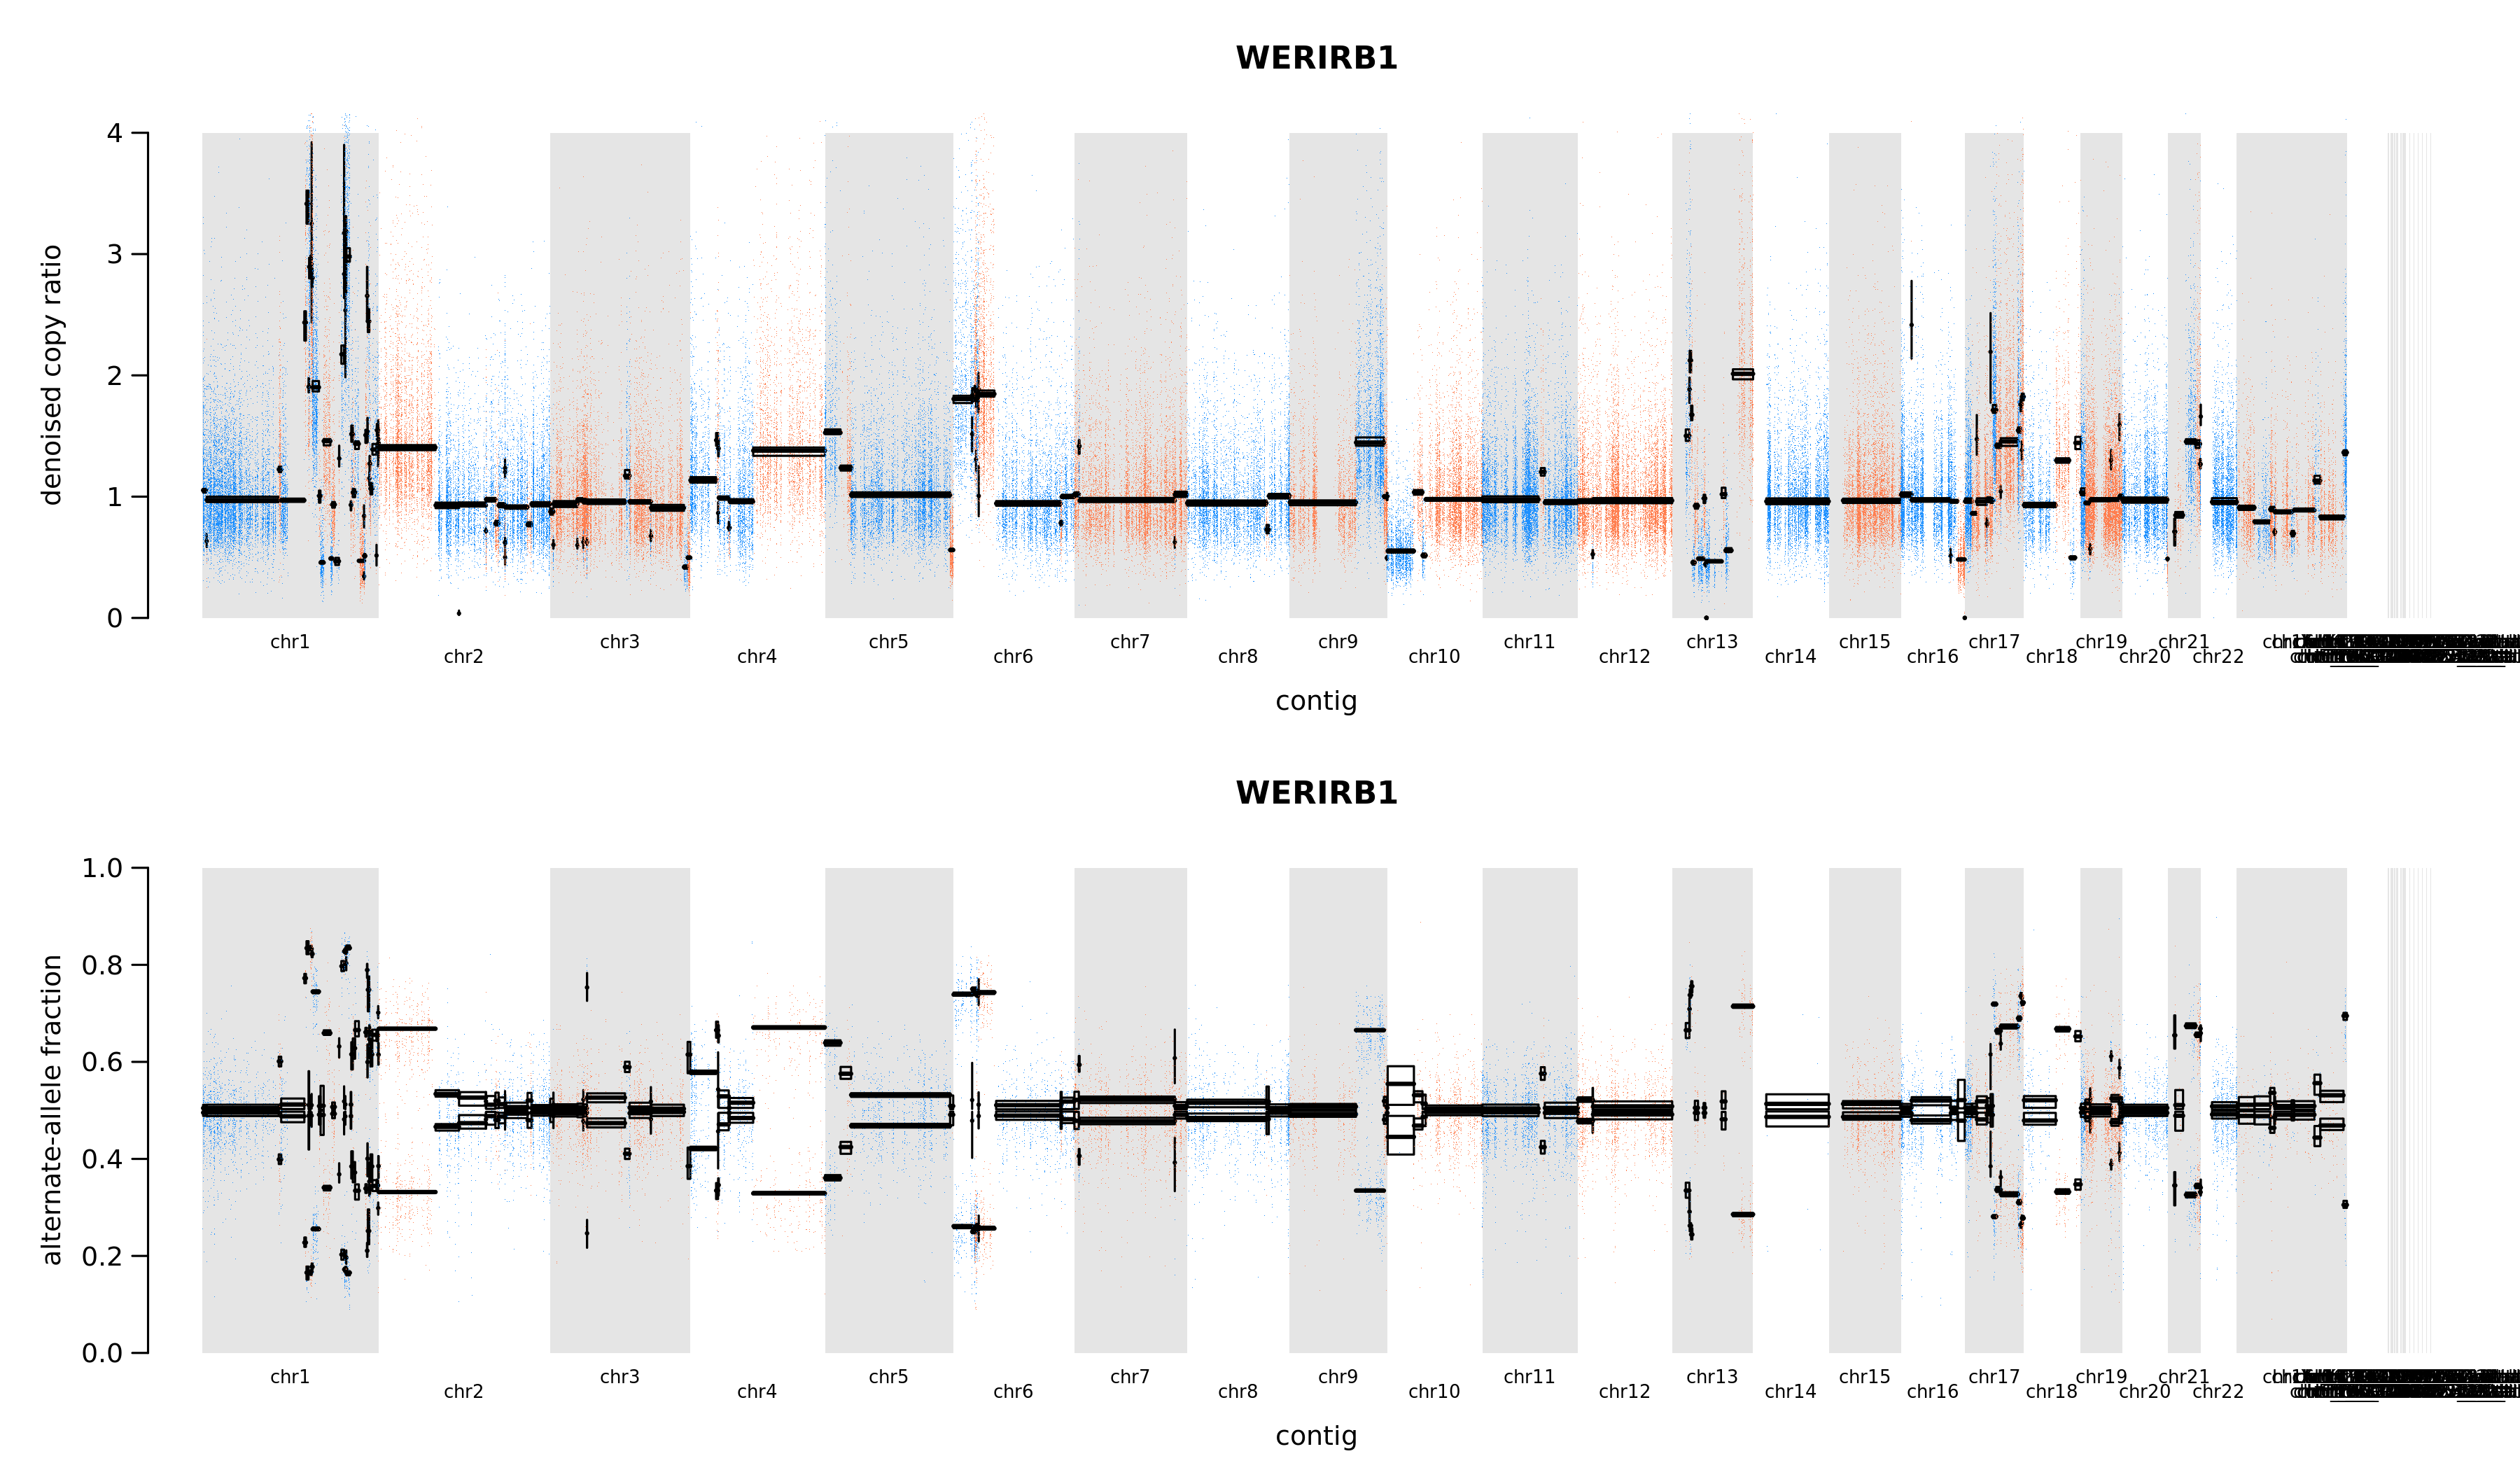

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/053a4666-0ac8-4760-8b79-aa11fa8c4e89/call-PlotModeledSegmentsTumor/out/ACH-001533_1.hg38.modeled.png...
/ [1 files][517.7 KiB/517.7 KiB]                                                
Operation completed over 1 objects/517.7 KiB.                                    
ACH-001533_1


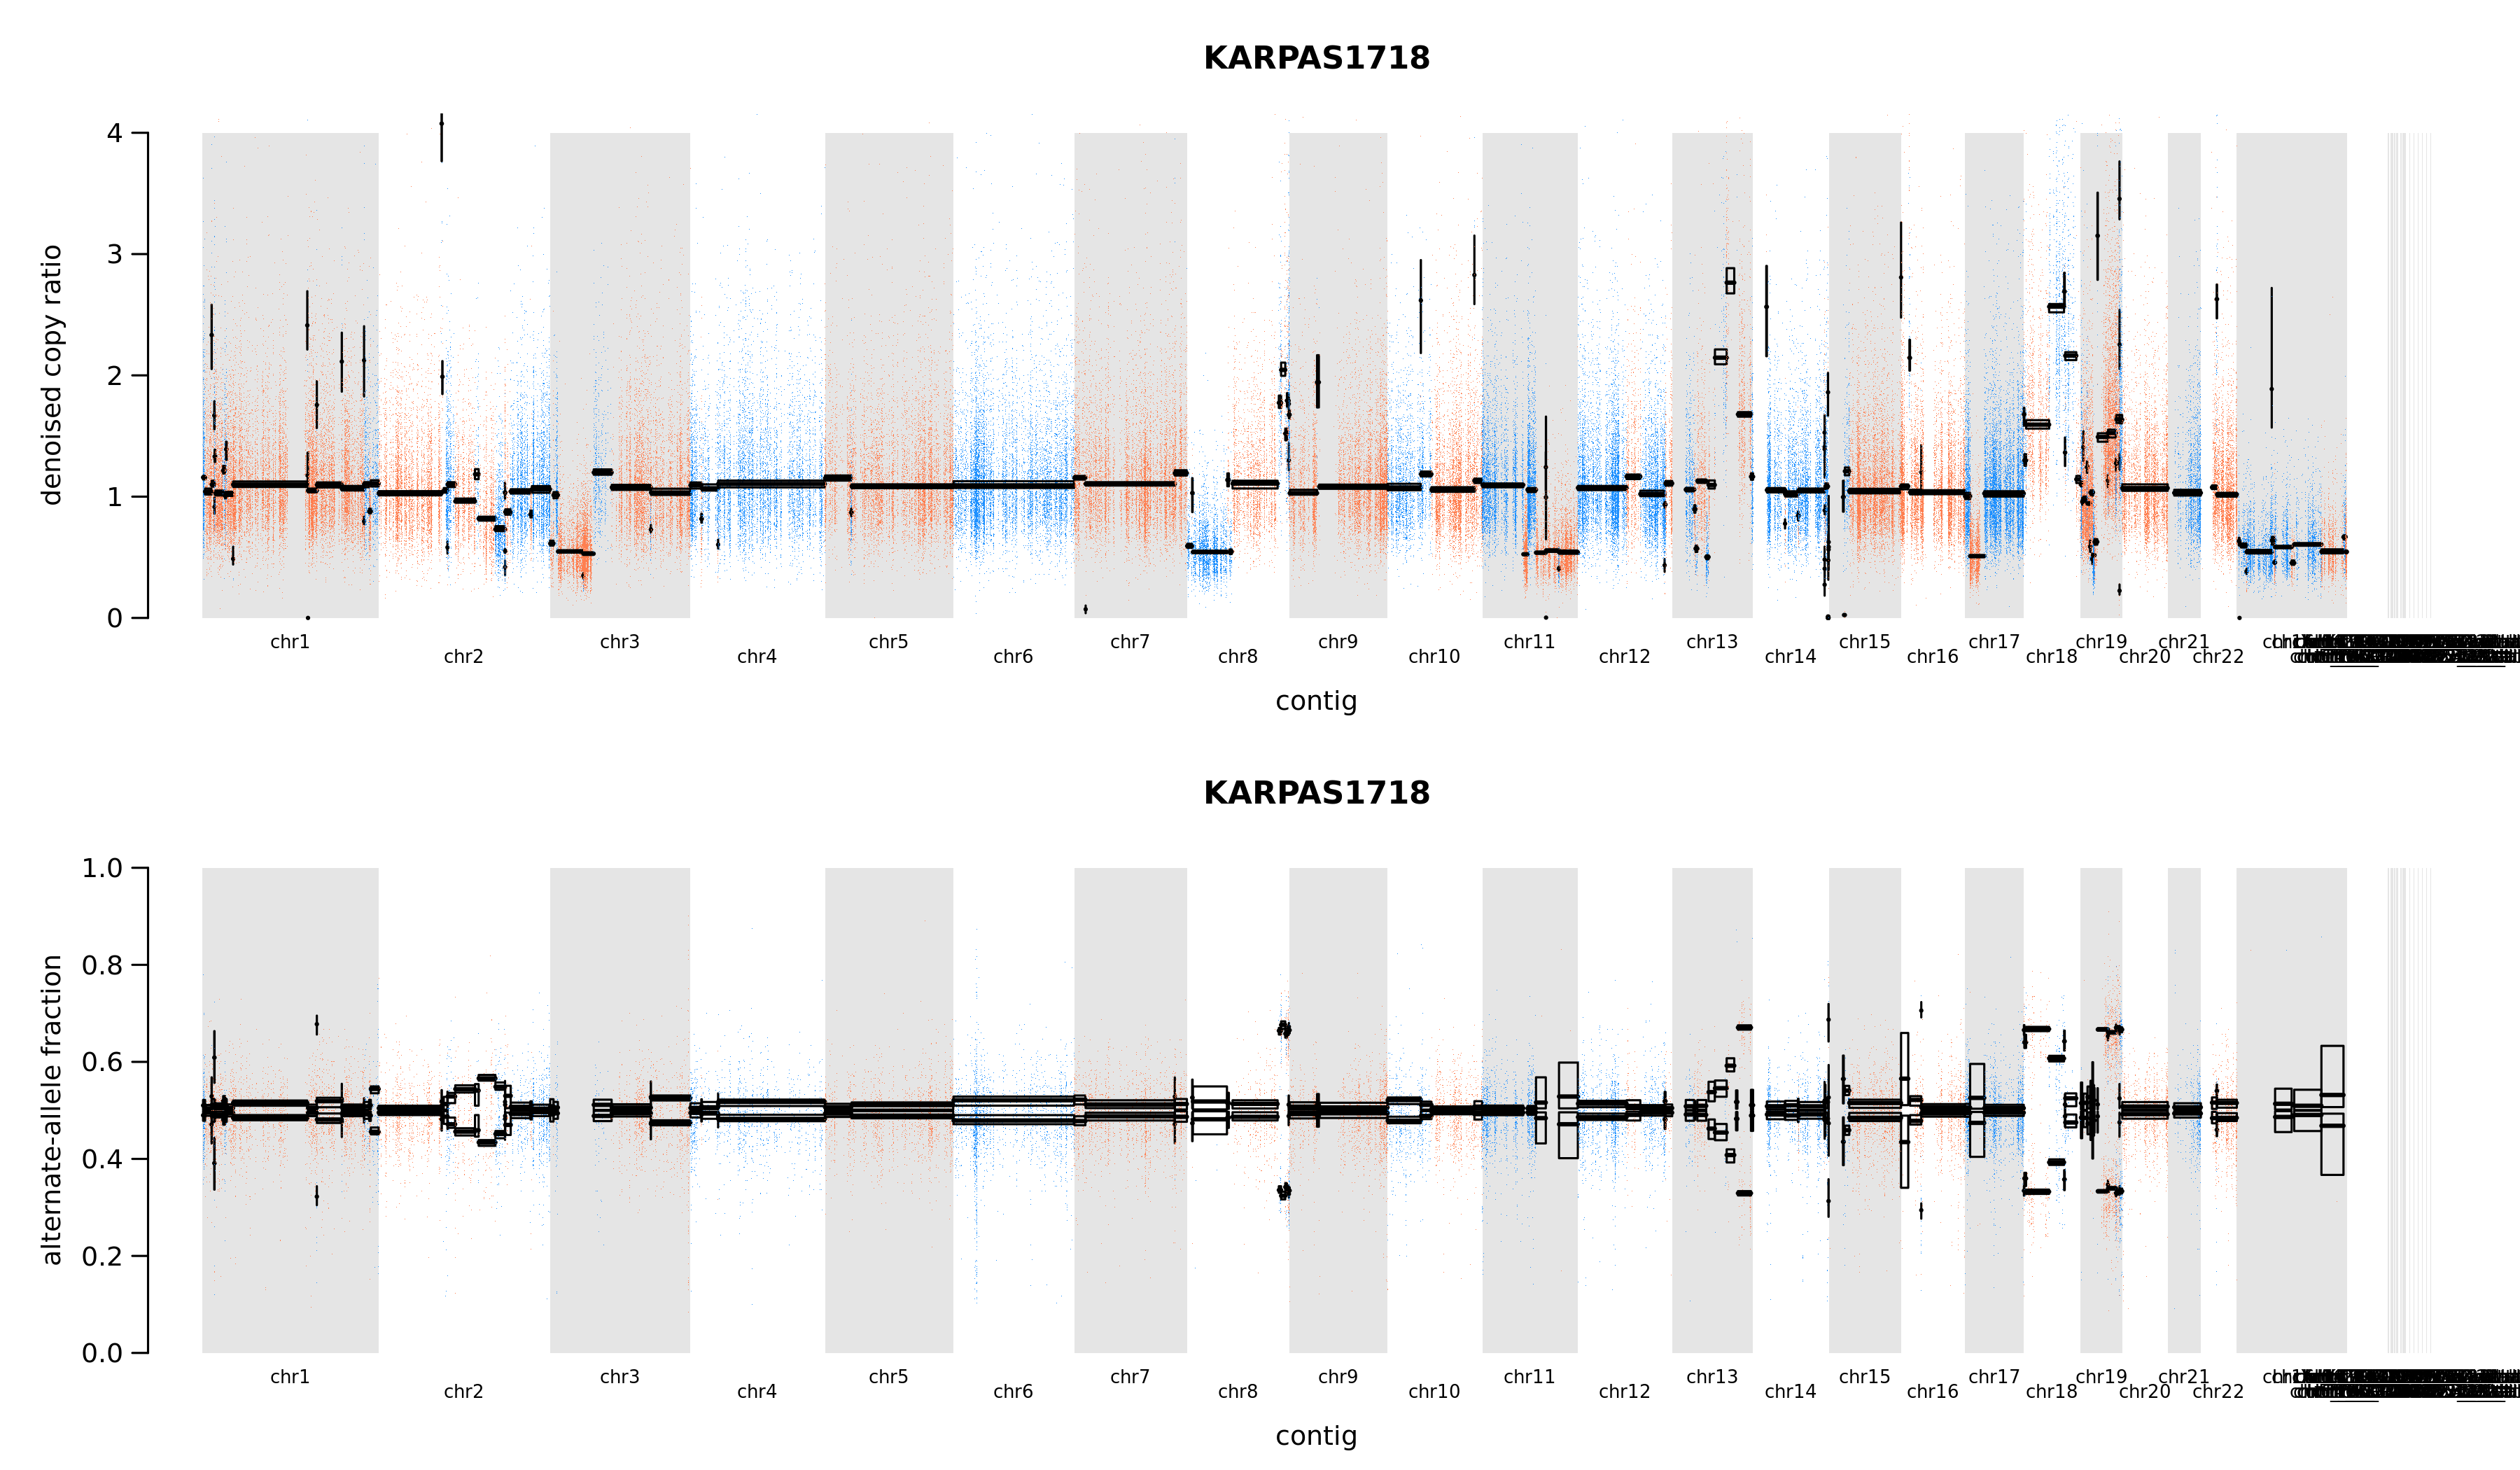

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/4ae814fe-97b7-4c3a-9b7f-66f9b30addc0/call-PlotModeledSegmentsTumor/out/ACH-001574_1.hg38.modeled.png...
/ [1 files][492.7 KiB/492.7 KiB]                                                
Operation completed over 1 objects/492.7 KiB.                                    
ACH-001574_1


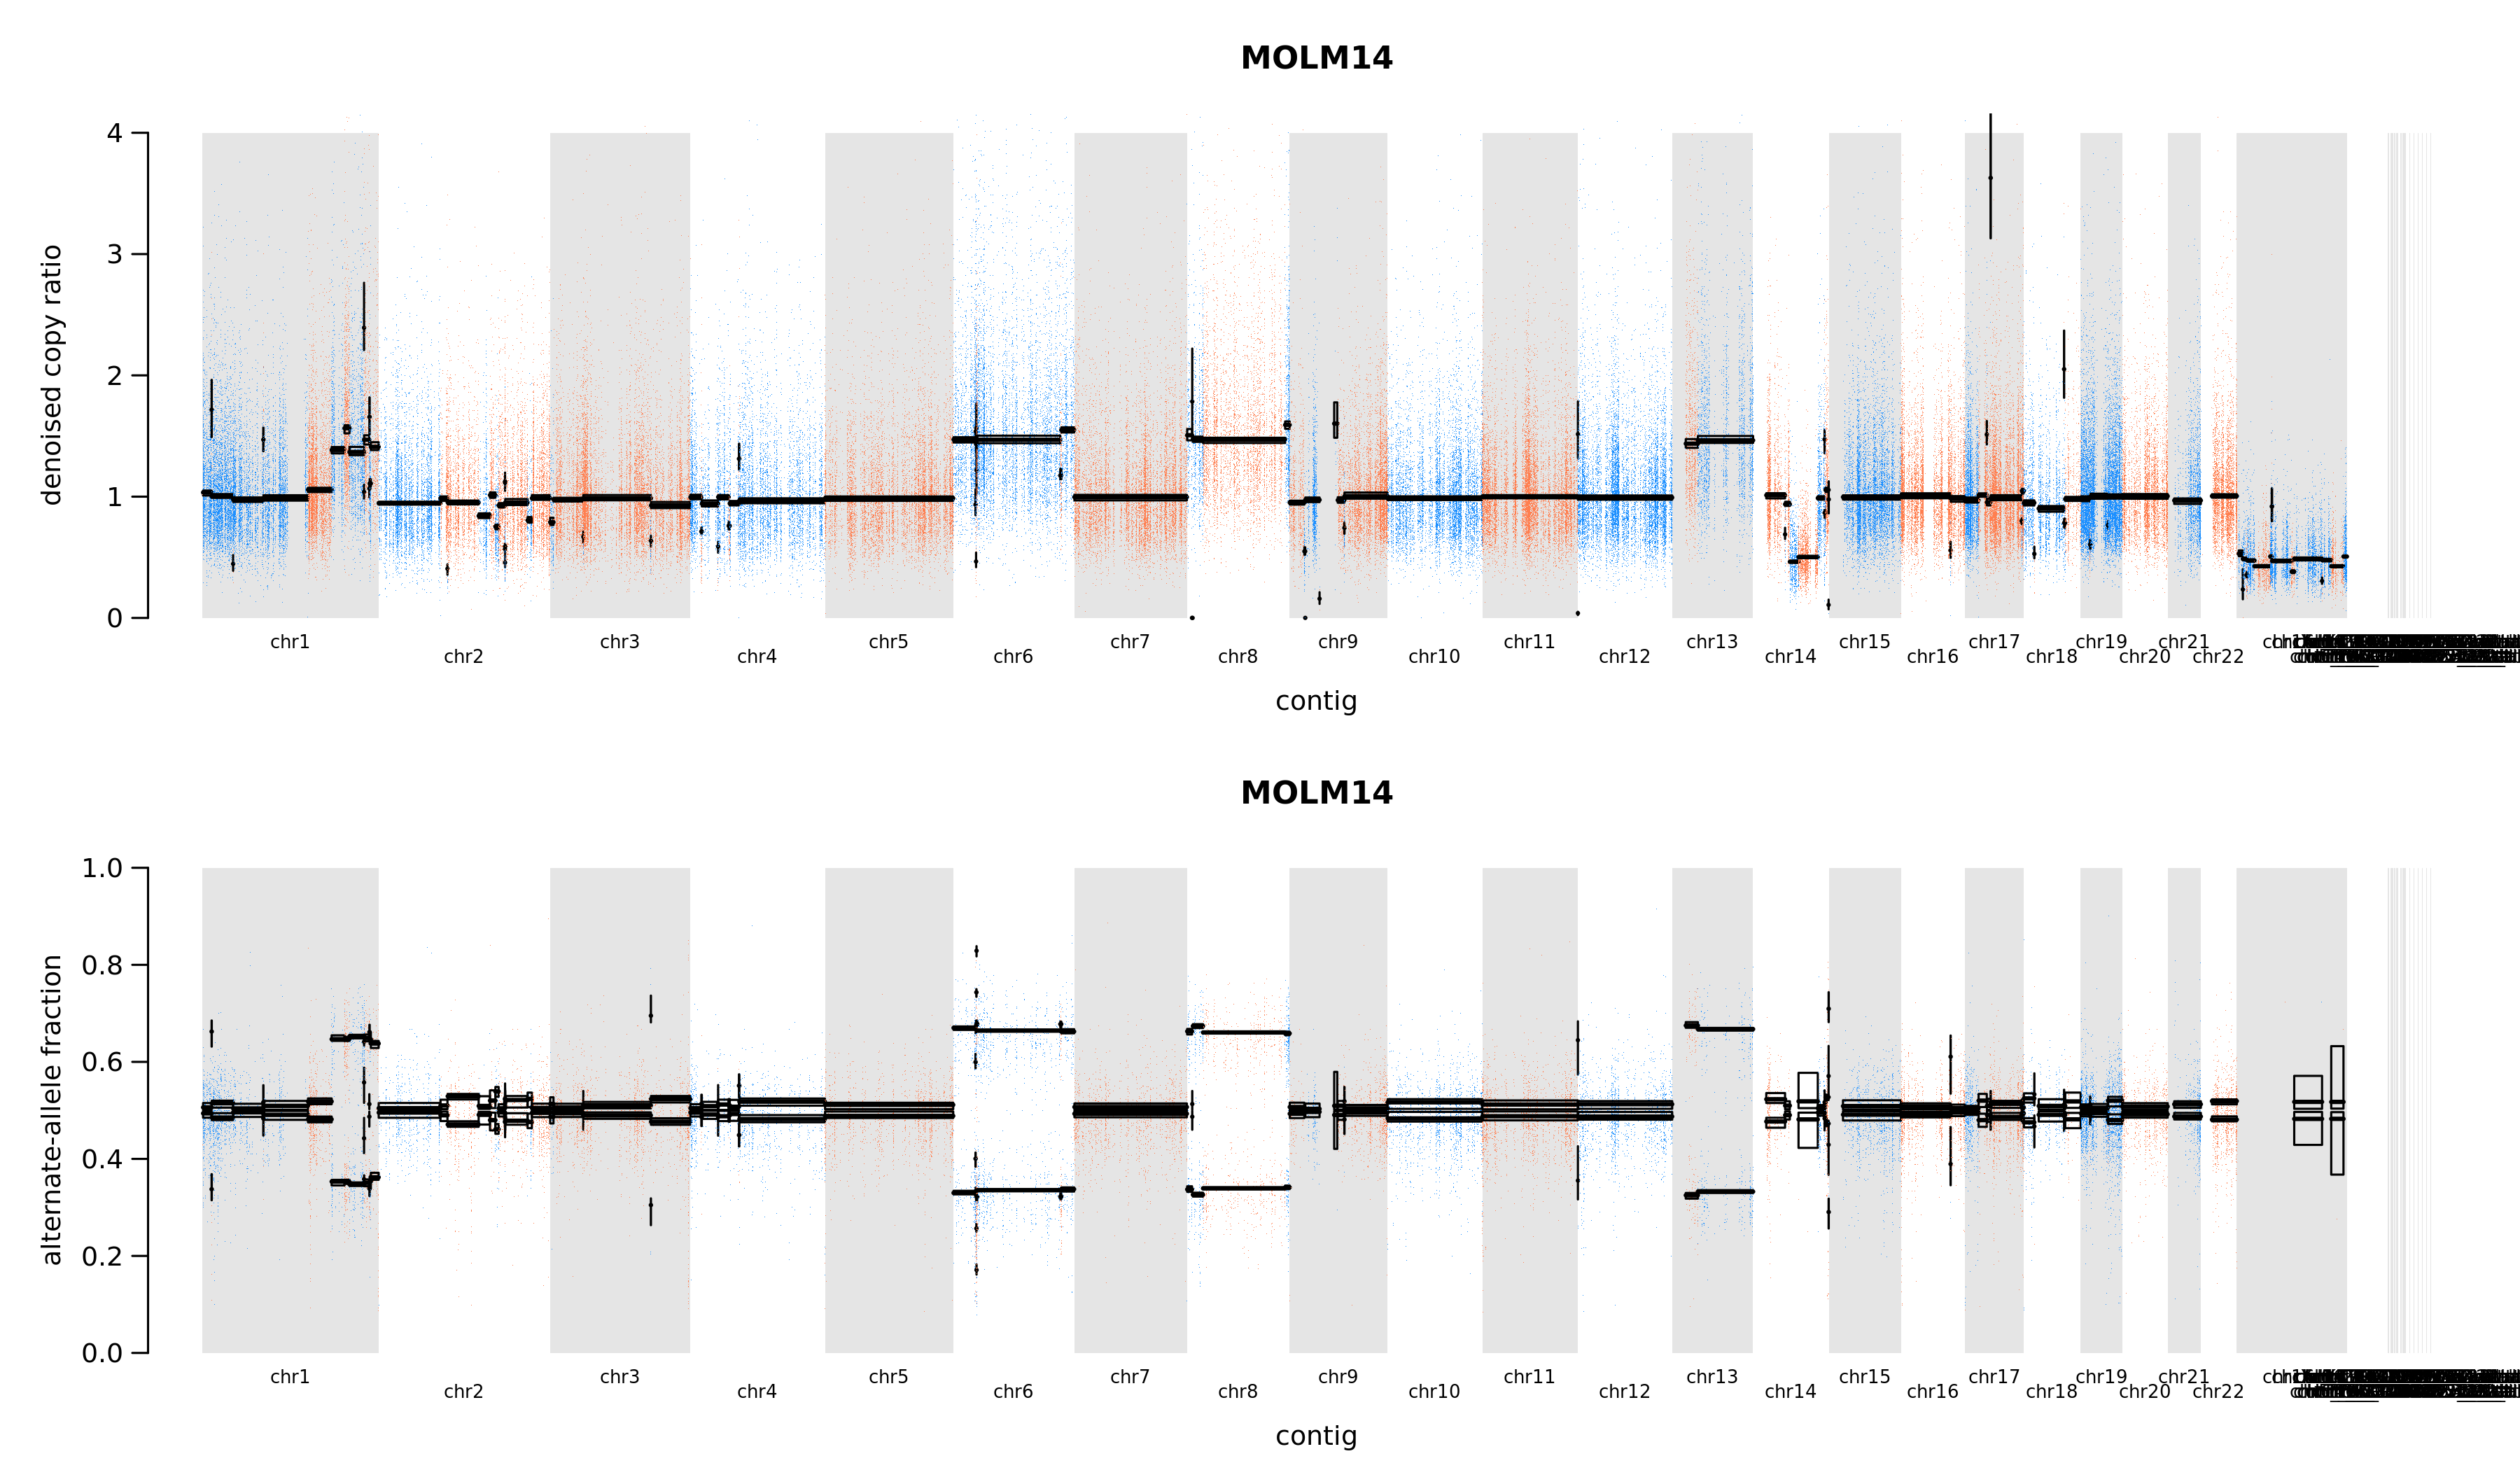

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/ed0b002e-b672-47dc-aa34-7999fef6f150/call-PlotModeledSegmentsTumor/out/ACH-001678_1.hg38.modeled.png...
/ [1 files][527.1 KiB/527.1 KiB]                                                
Operation completed over 1 objects/527.1 KiB.                                    
ACH-001678_1


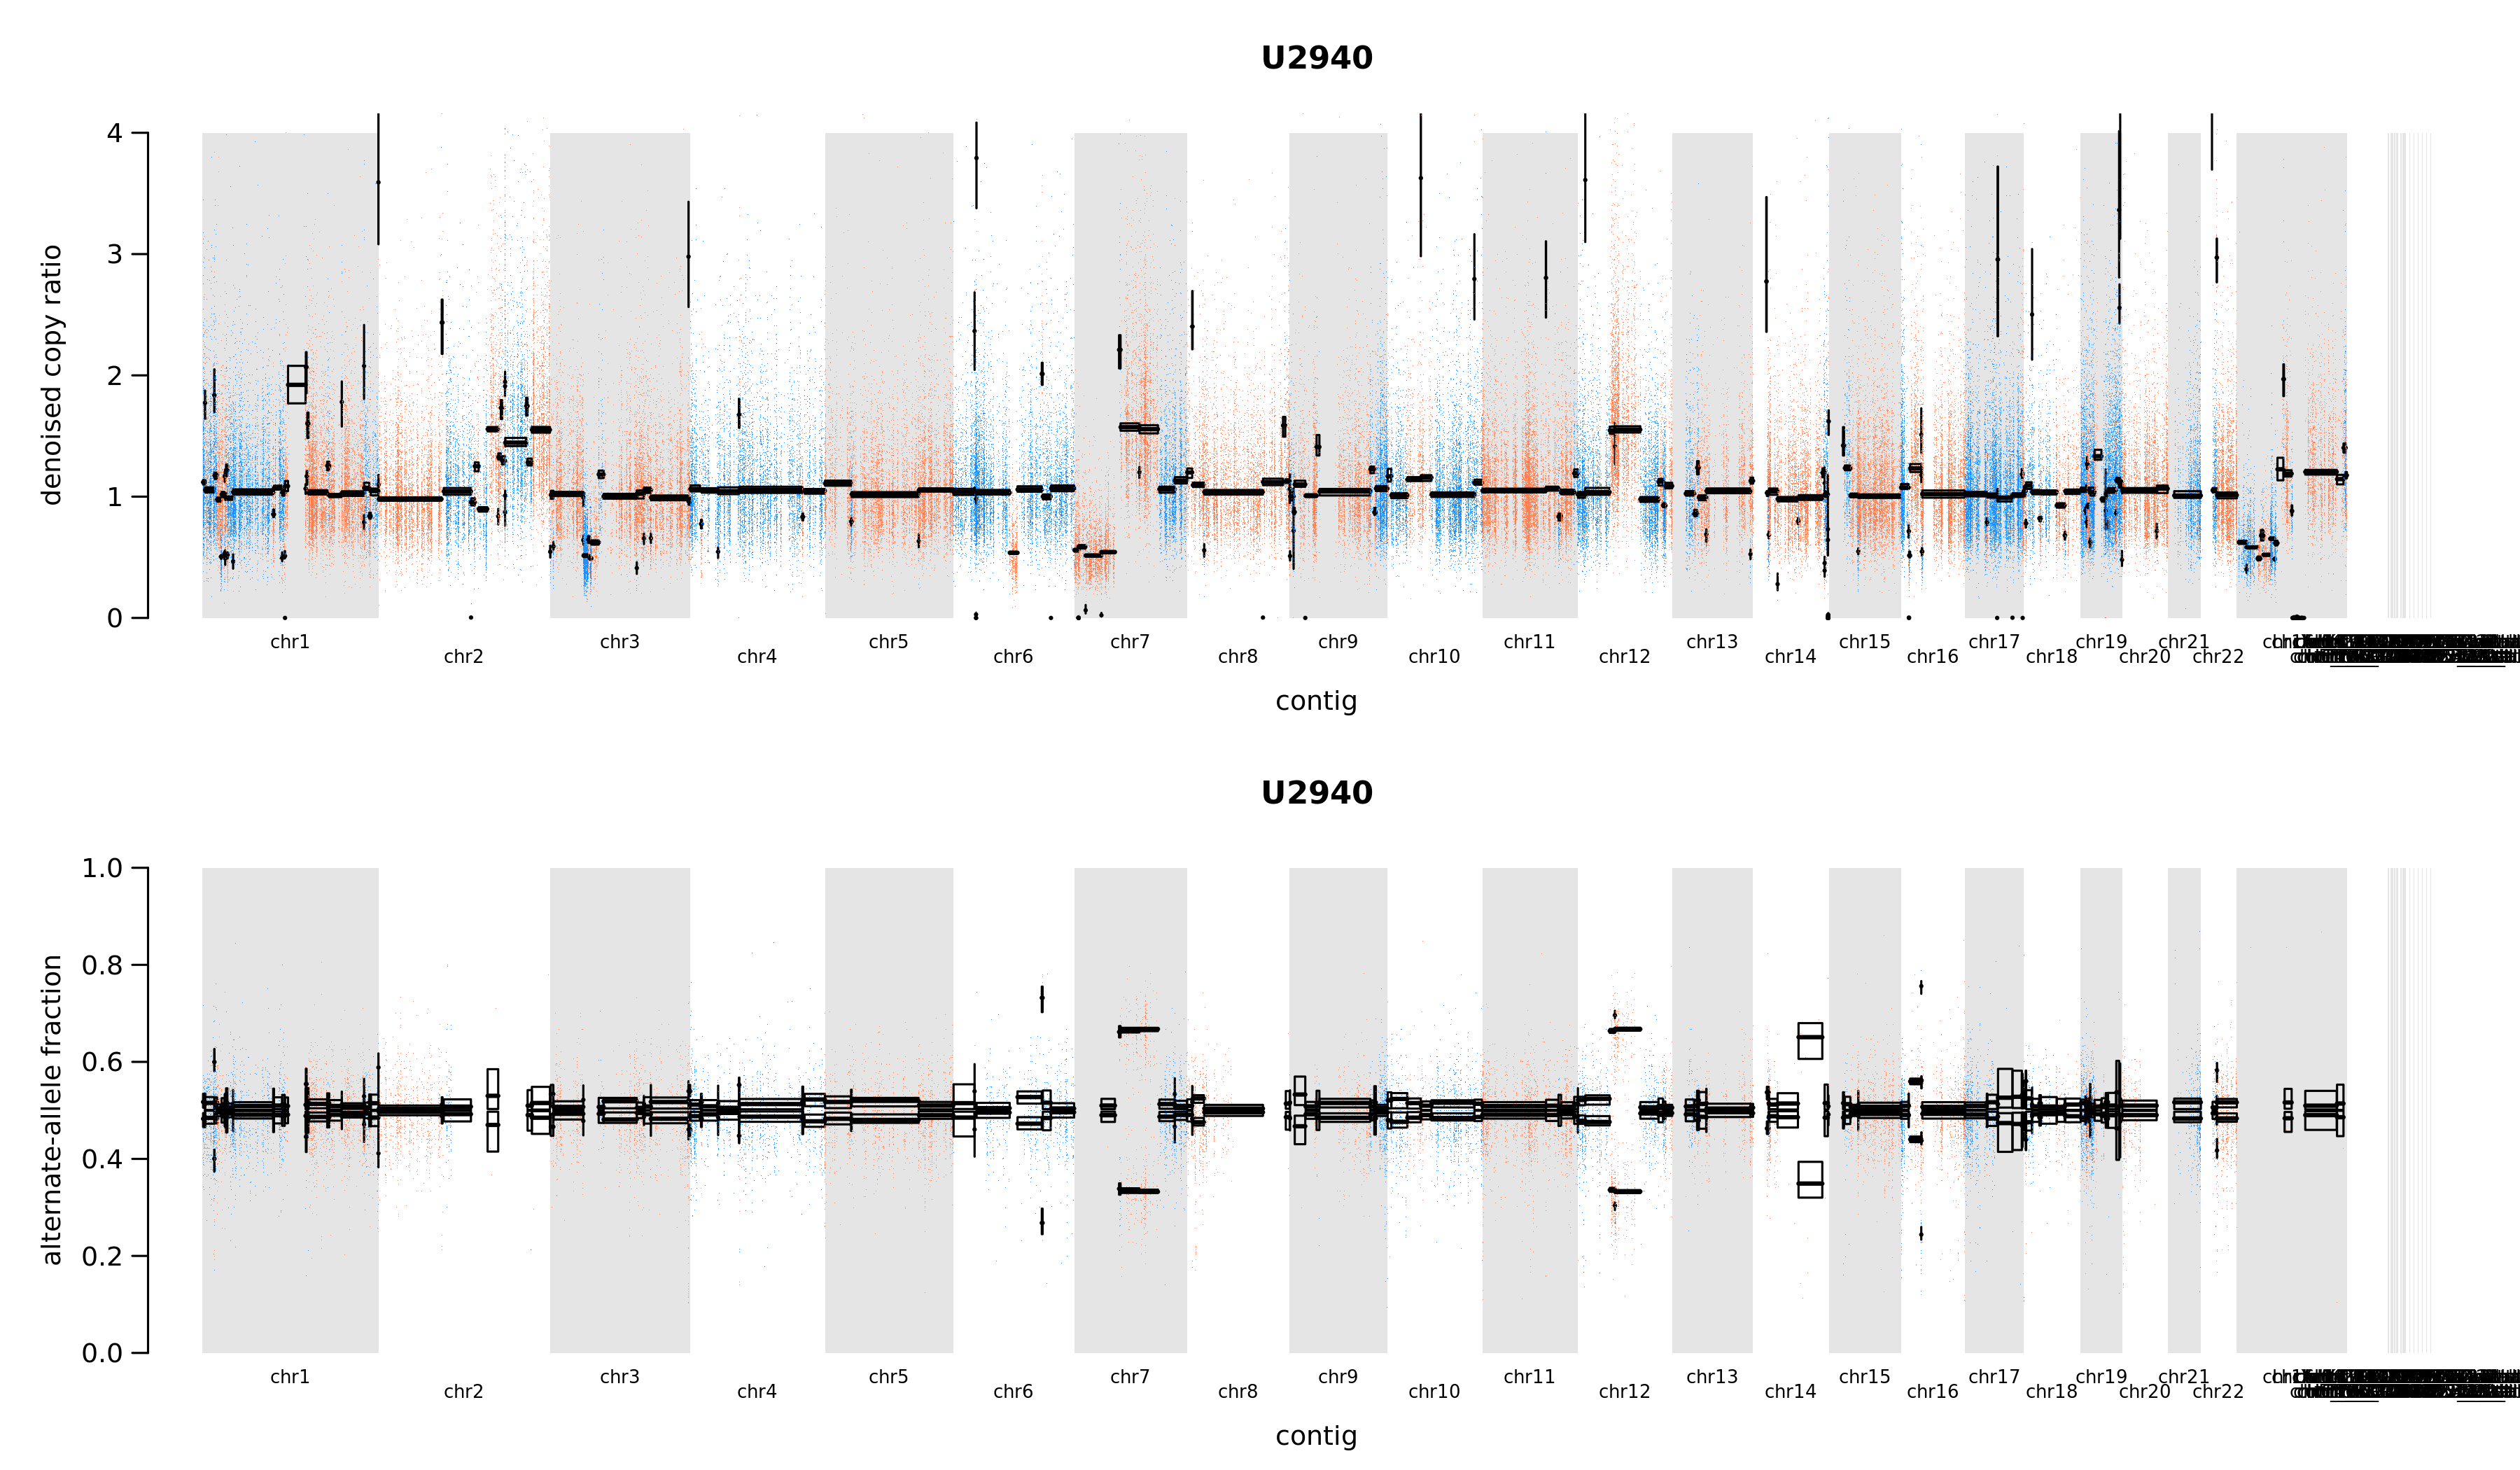

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/f28e8676-aa5b-43ab-8ee2-17f2bd6692fe/call-PlotModeledSegmentsTumor/out/ACH-001711_3.hg38.modeled.png...
/ [1 files][441.4 KiB/441.4 KiB]                                                
Operation completed over 1 objects/441.4 KiB.                                    
ACH-001711_3


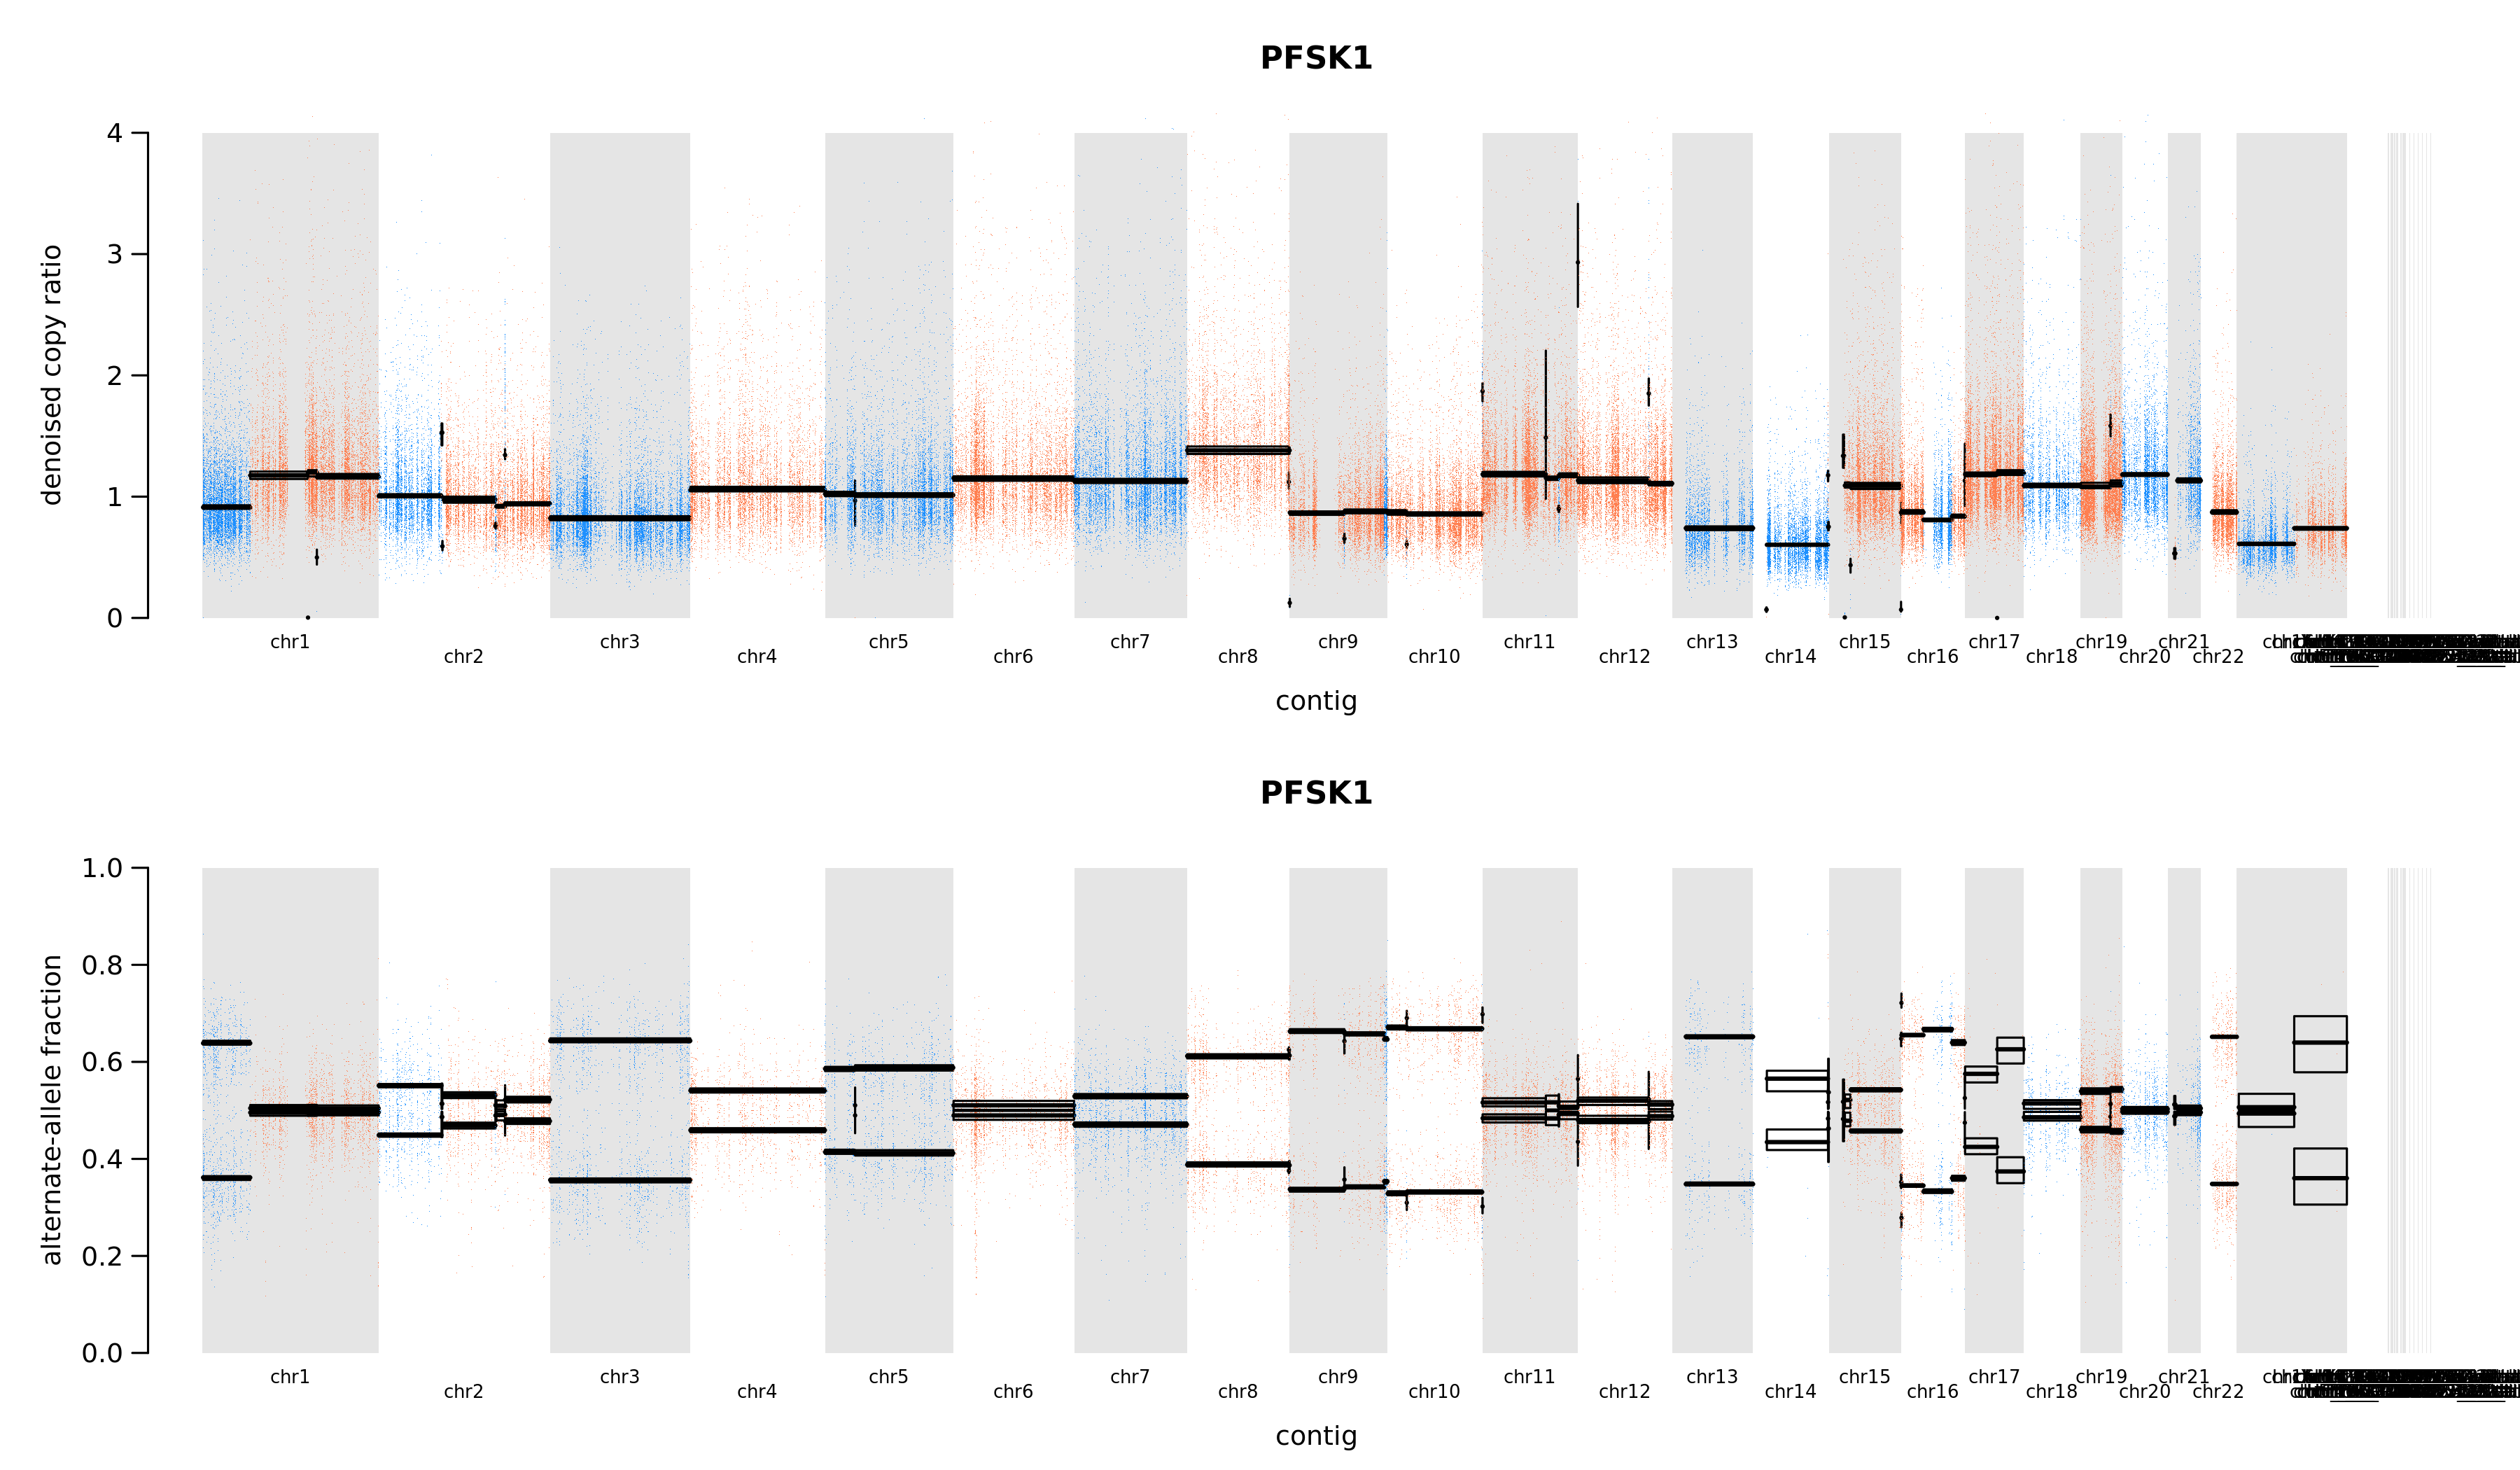

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/98c3e70e-4941-4739-8255-a10abe592b78/call-PlotModeledSegmentsTumor/out/ACH-001847_1.hg38.modeled.png...
/ [1 files][519.4 KiB/519.4 KiB]                                                
Operation completed over 1 objects/519.4 KiB.                                    
ACH-001847_1


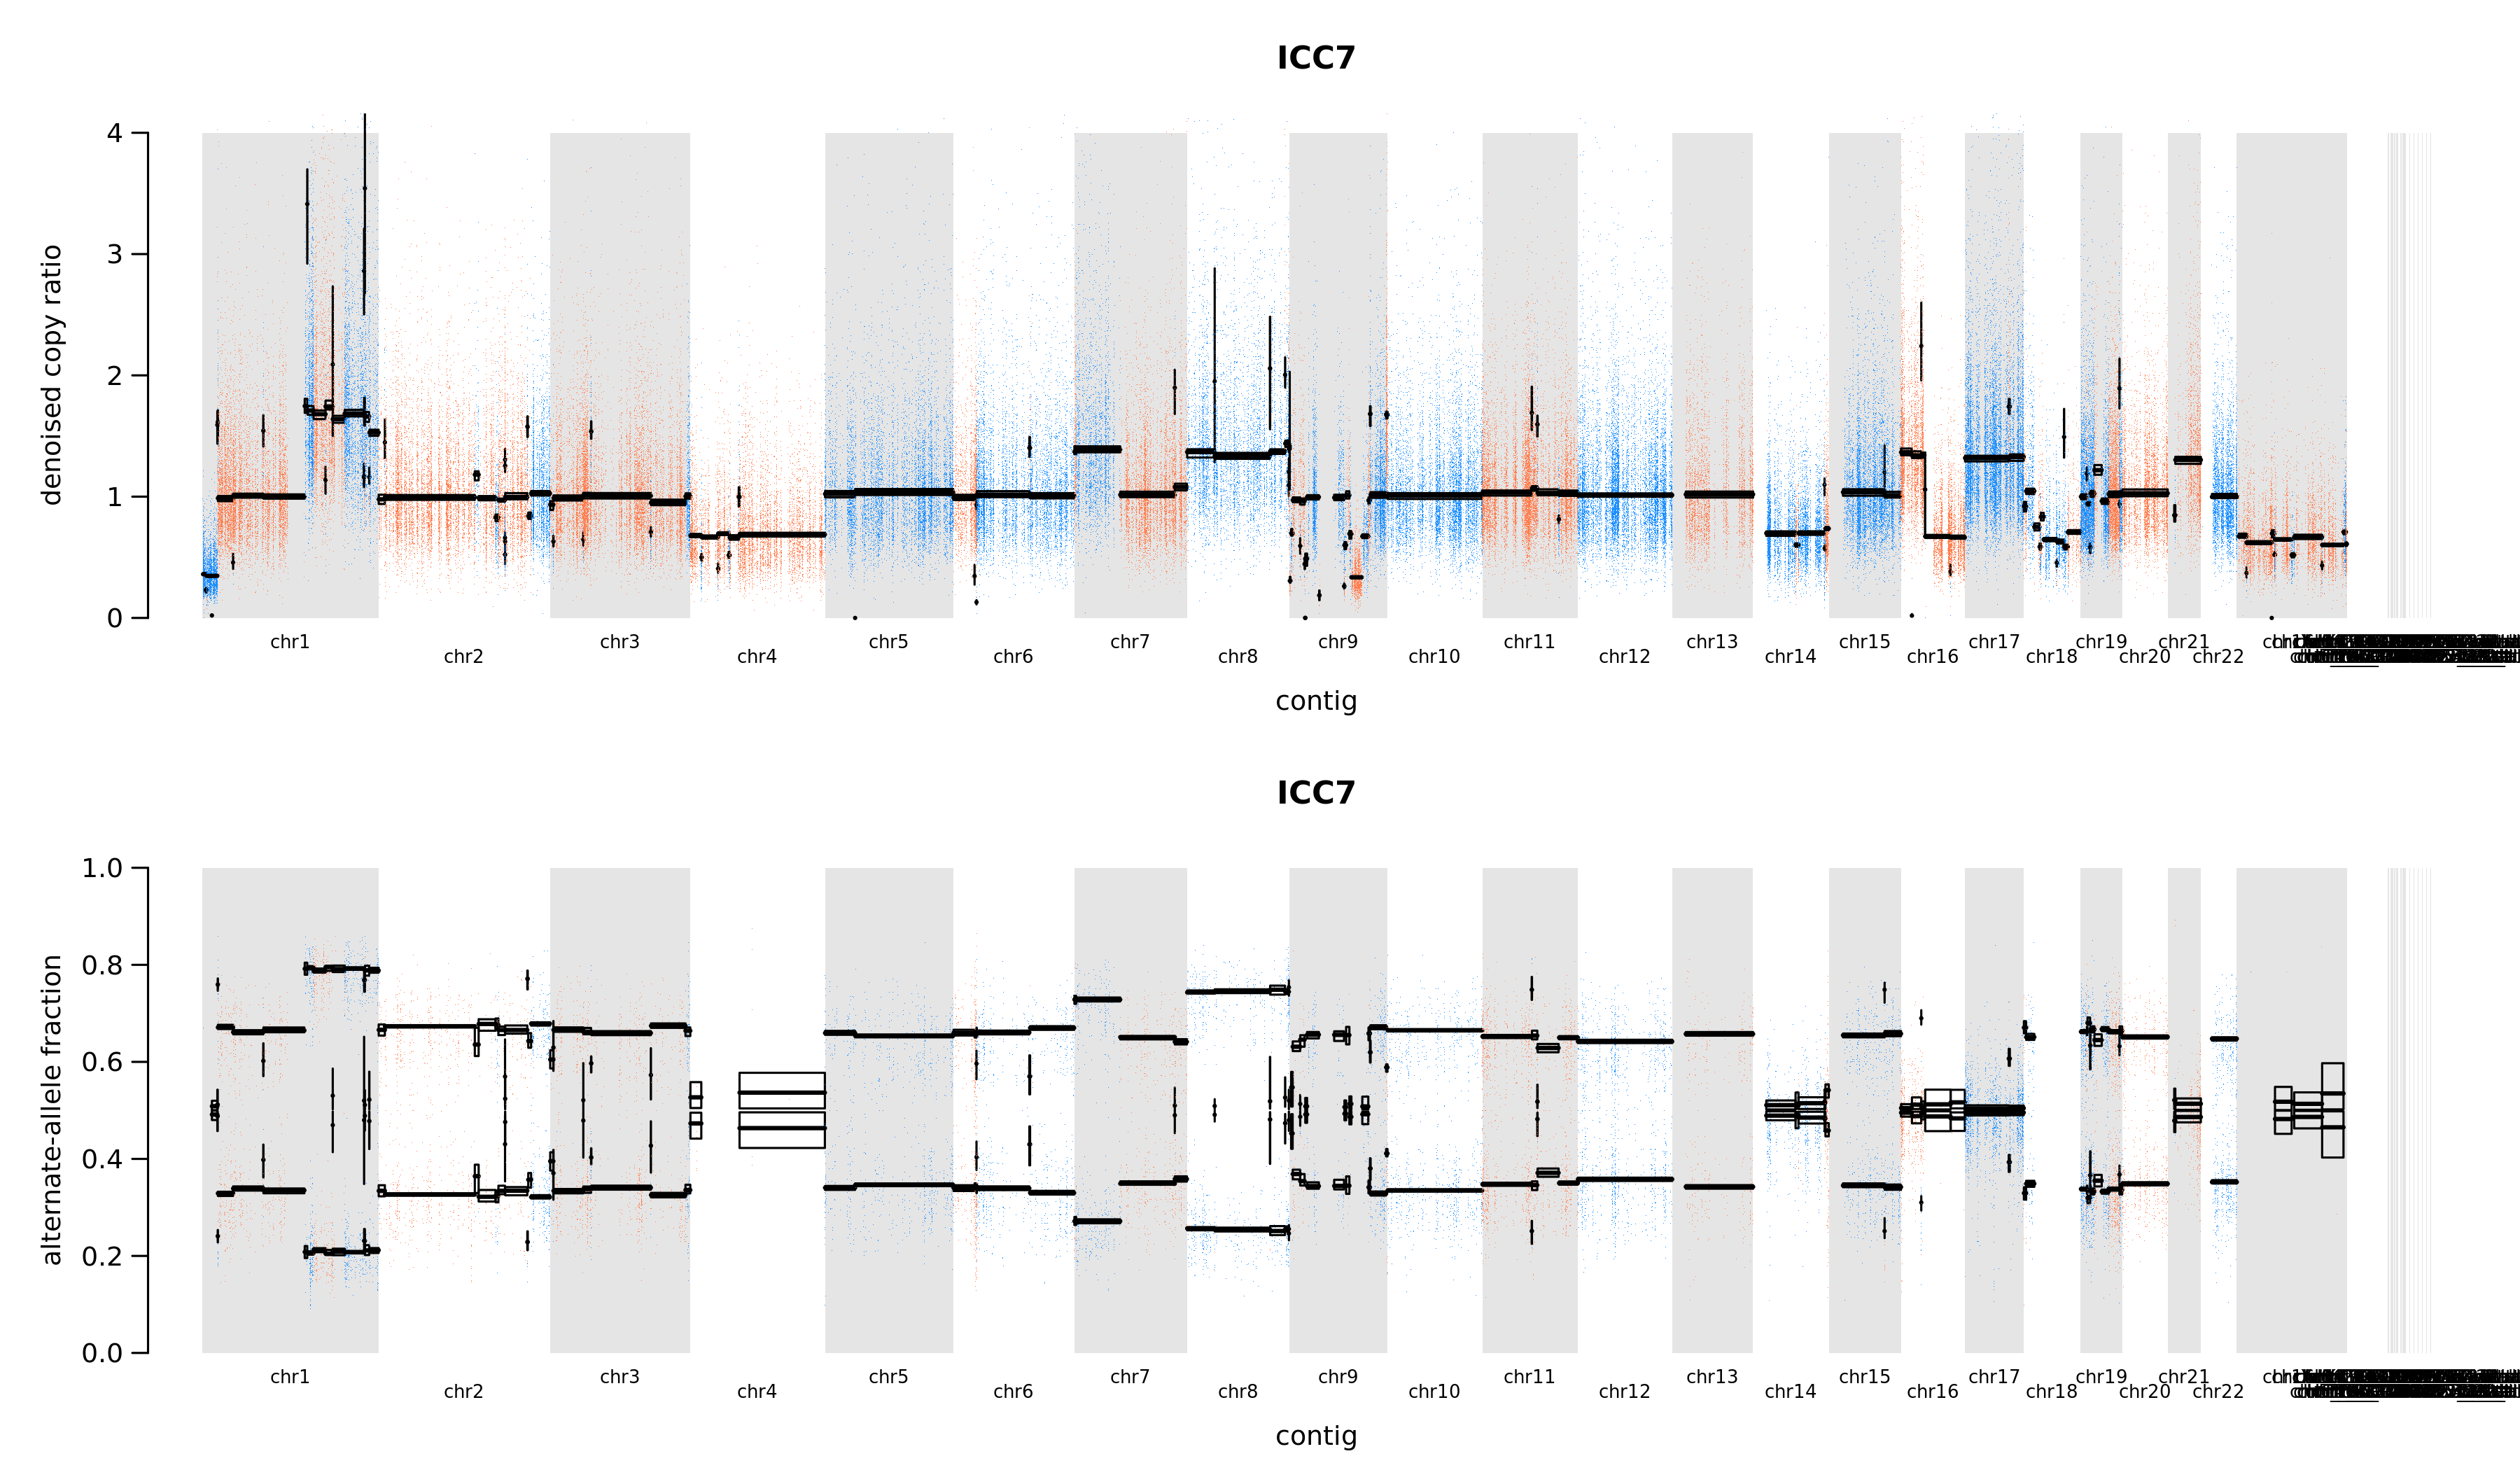

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/bffb2cbe-6e71-4beb-b7e9-4701ef104179/call-PlotModeledSegmentsTumor/out/ACH-002021_1.hg38.modeled.png...
/ [1 files][596.8 KiB/596.8 KiB]                                                
Operation completed over 1 objects/596.8 KiB.                                    
ACH-002021_1


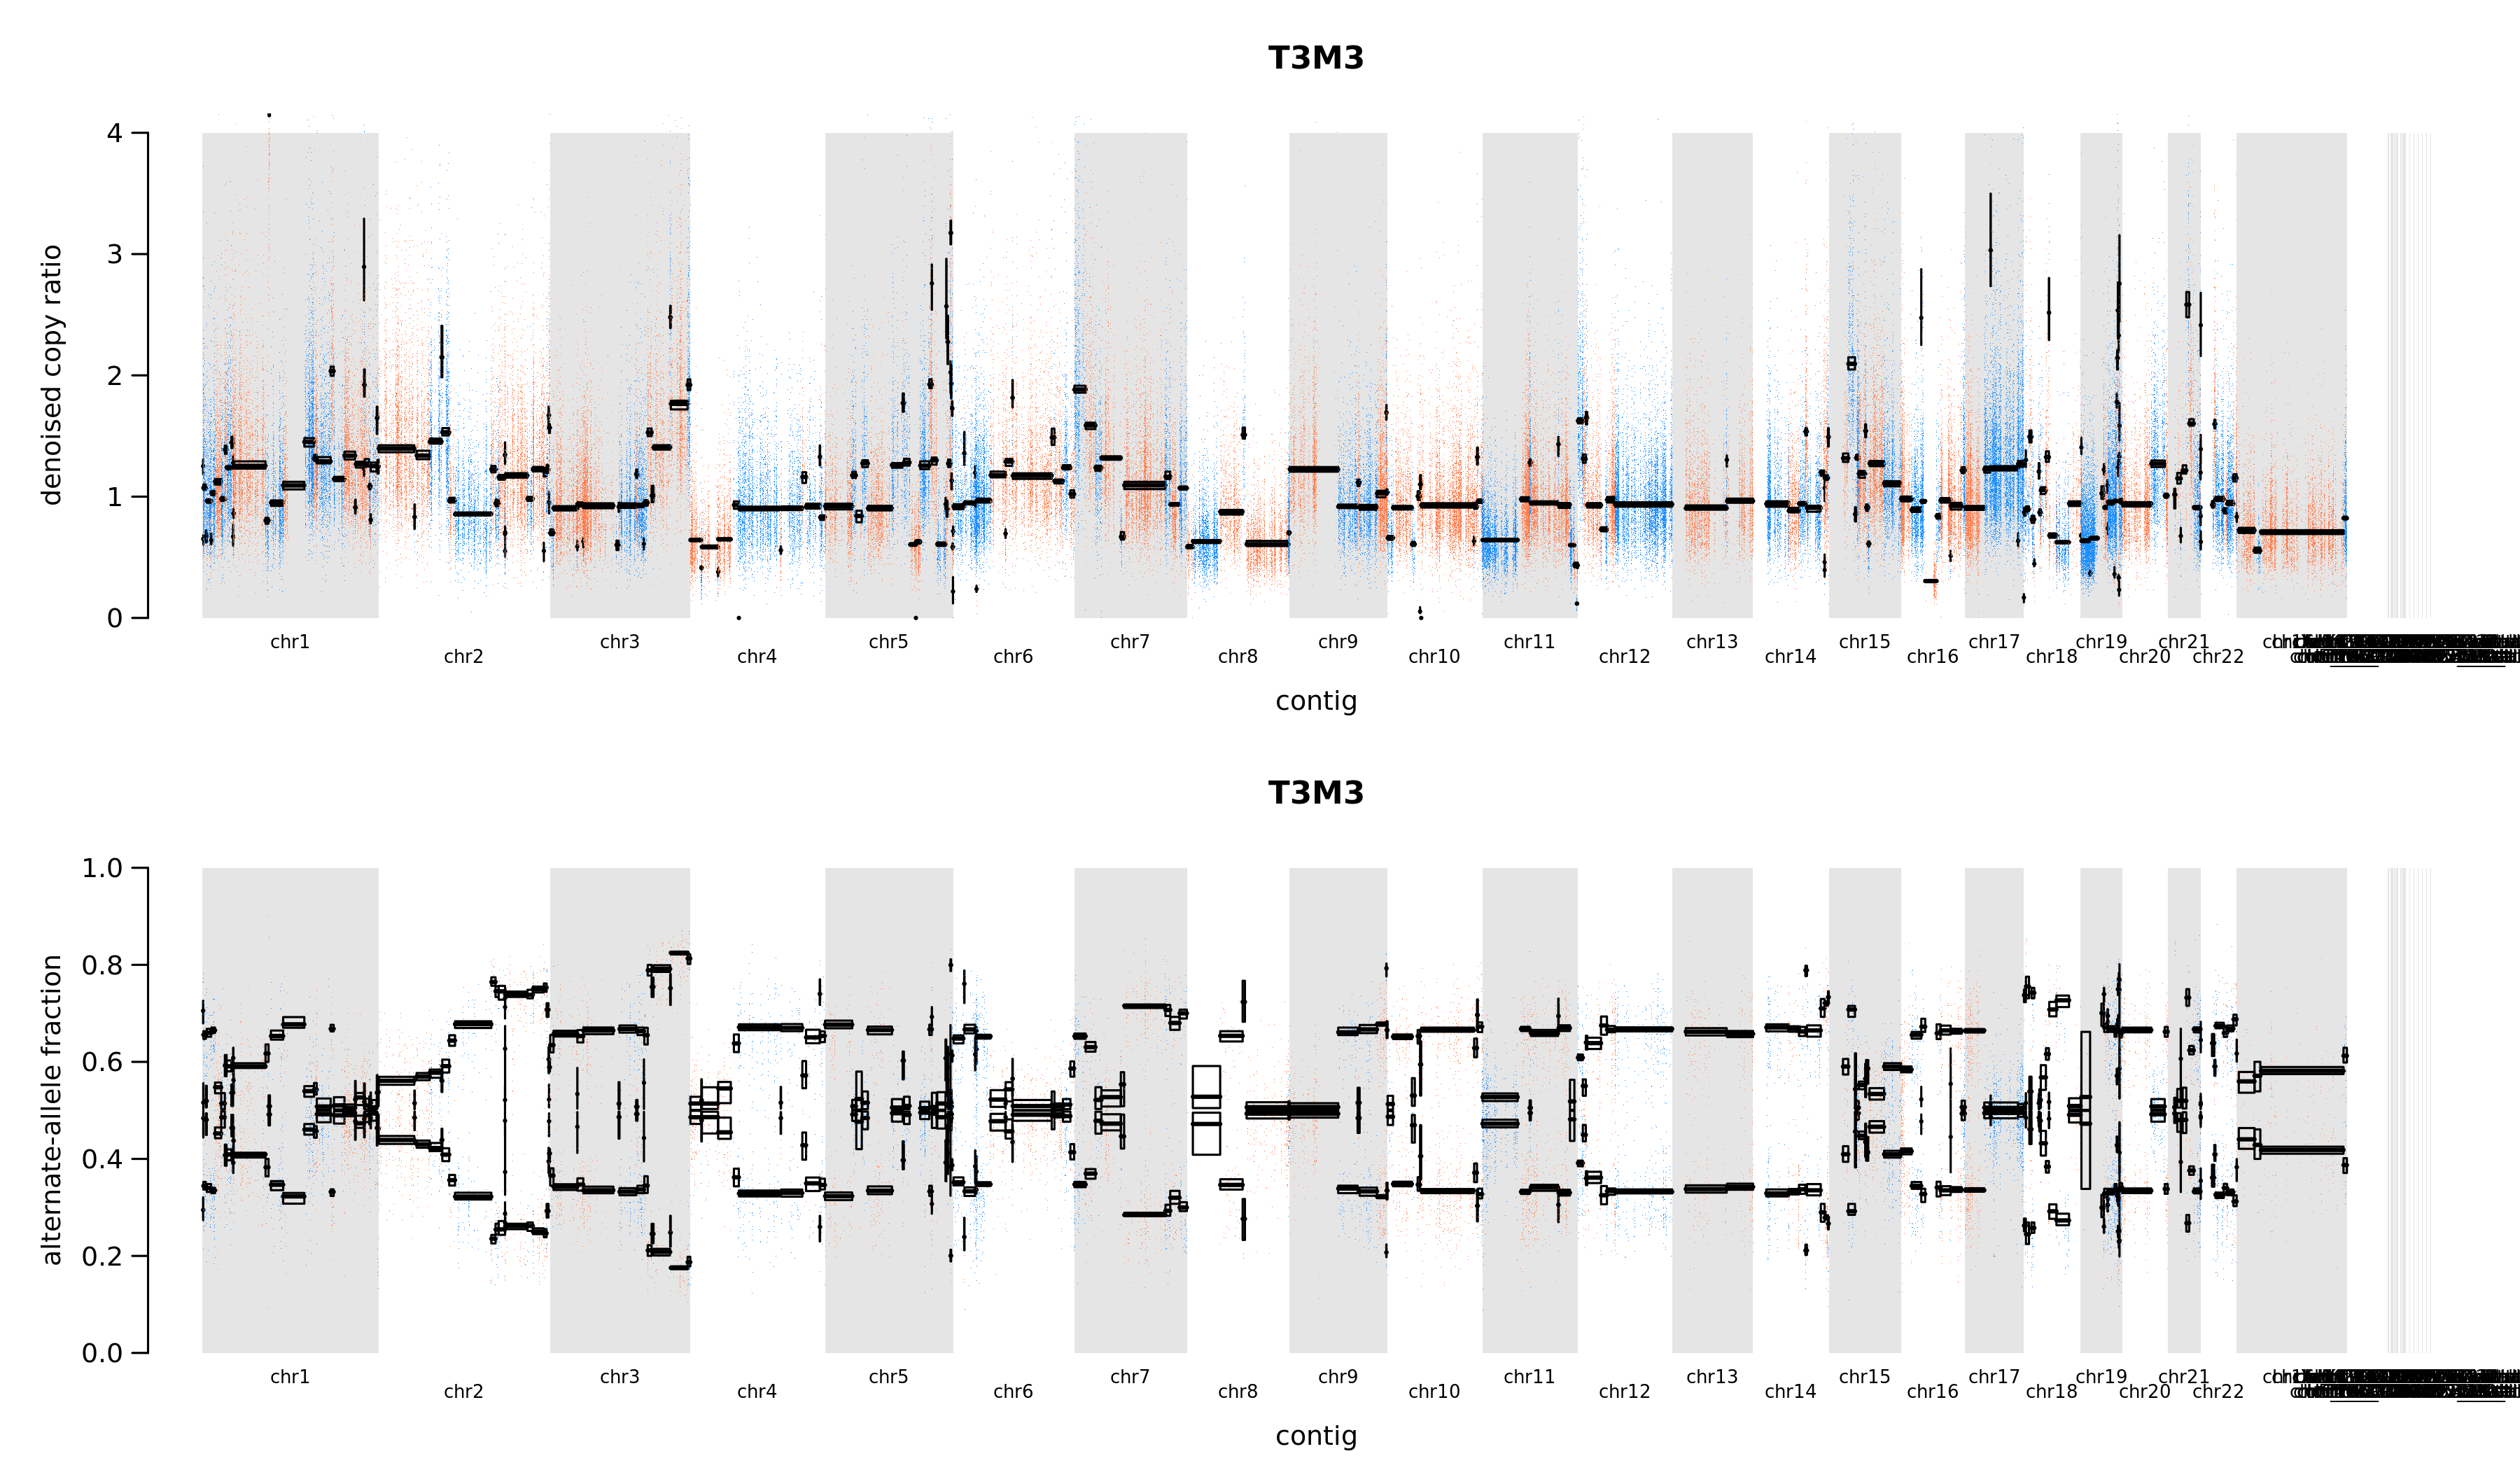

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/8afaf942-695b-4ca1-985f-b5566f7585a5/call-PlotModeledSegmentsTumor/attempt-2/out/ACH-002048_1.hg38.modeled.png...
/ [1 files][544.0 KiB/544.0 KiB]                                                
Operation completed over 1 objects/544.0 KiB.                                    
ACH-002048_1


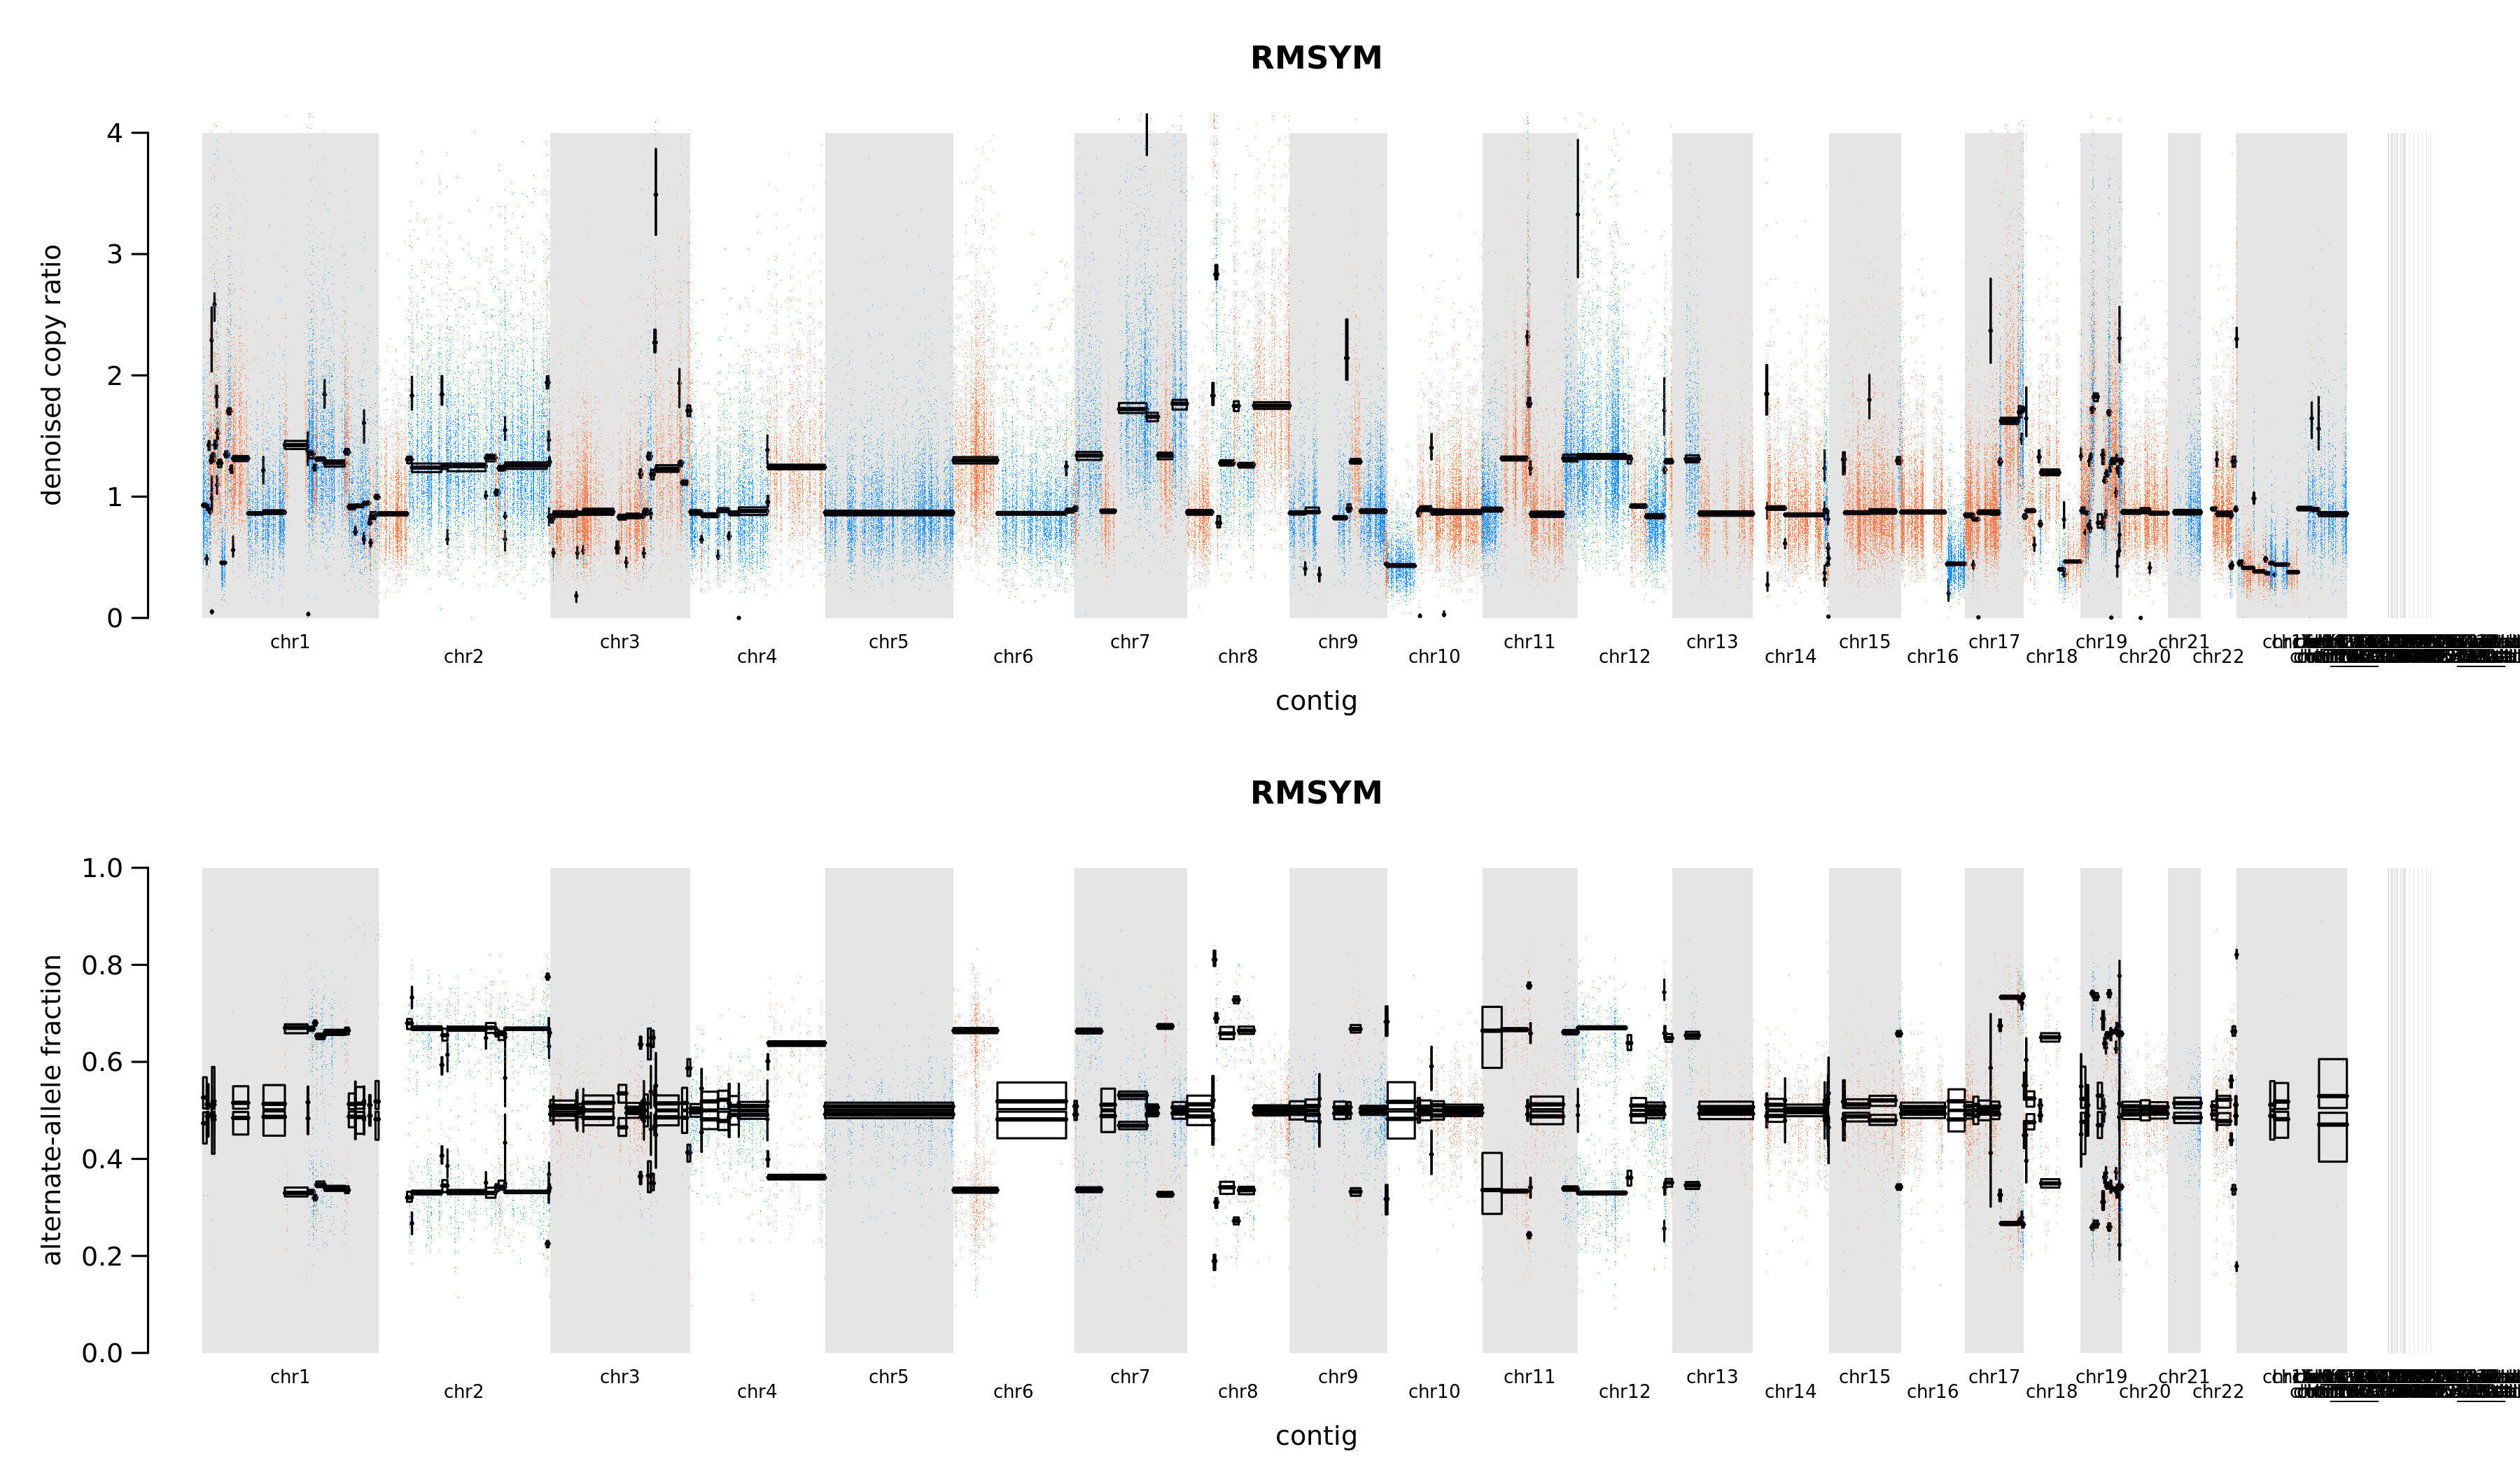

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/f1eb8512-8a3b-4e50-9f8c-4300a58077d2/call-PlotModeledSegmentsTumor/out/ACH-002065_1.hg38.modeled.png...
/ [1 files][478.4 KiB/478.4 KiB]                                                
Operation completed over 1 objects/478.4 KiB.                                    
ACH-002065_1


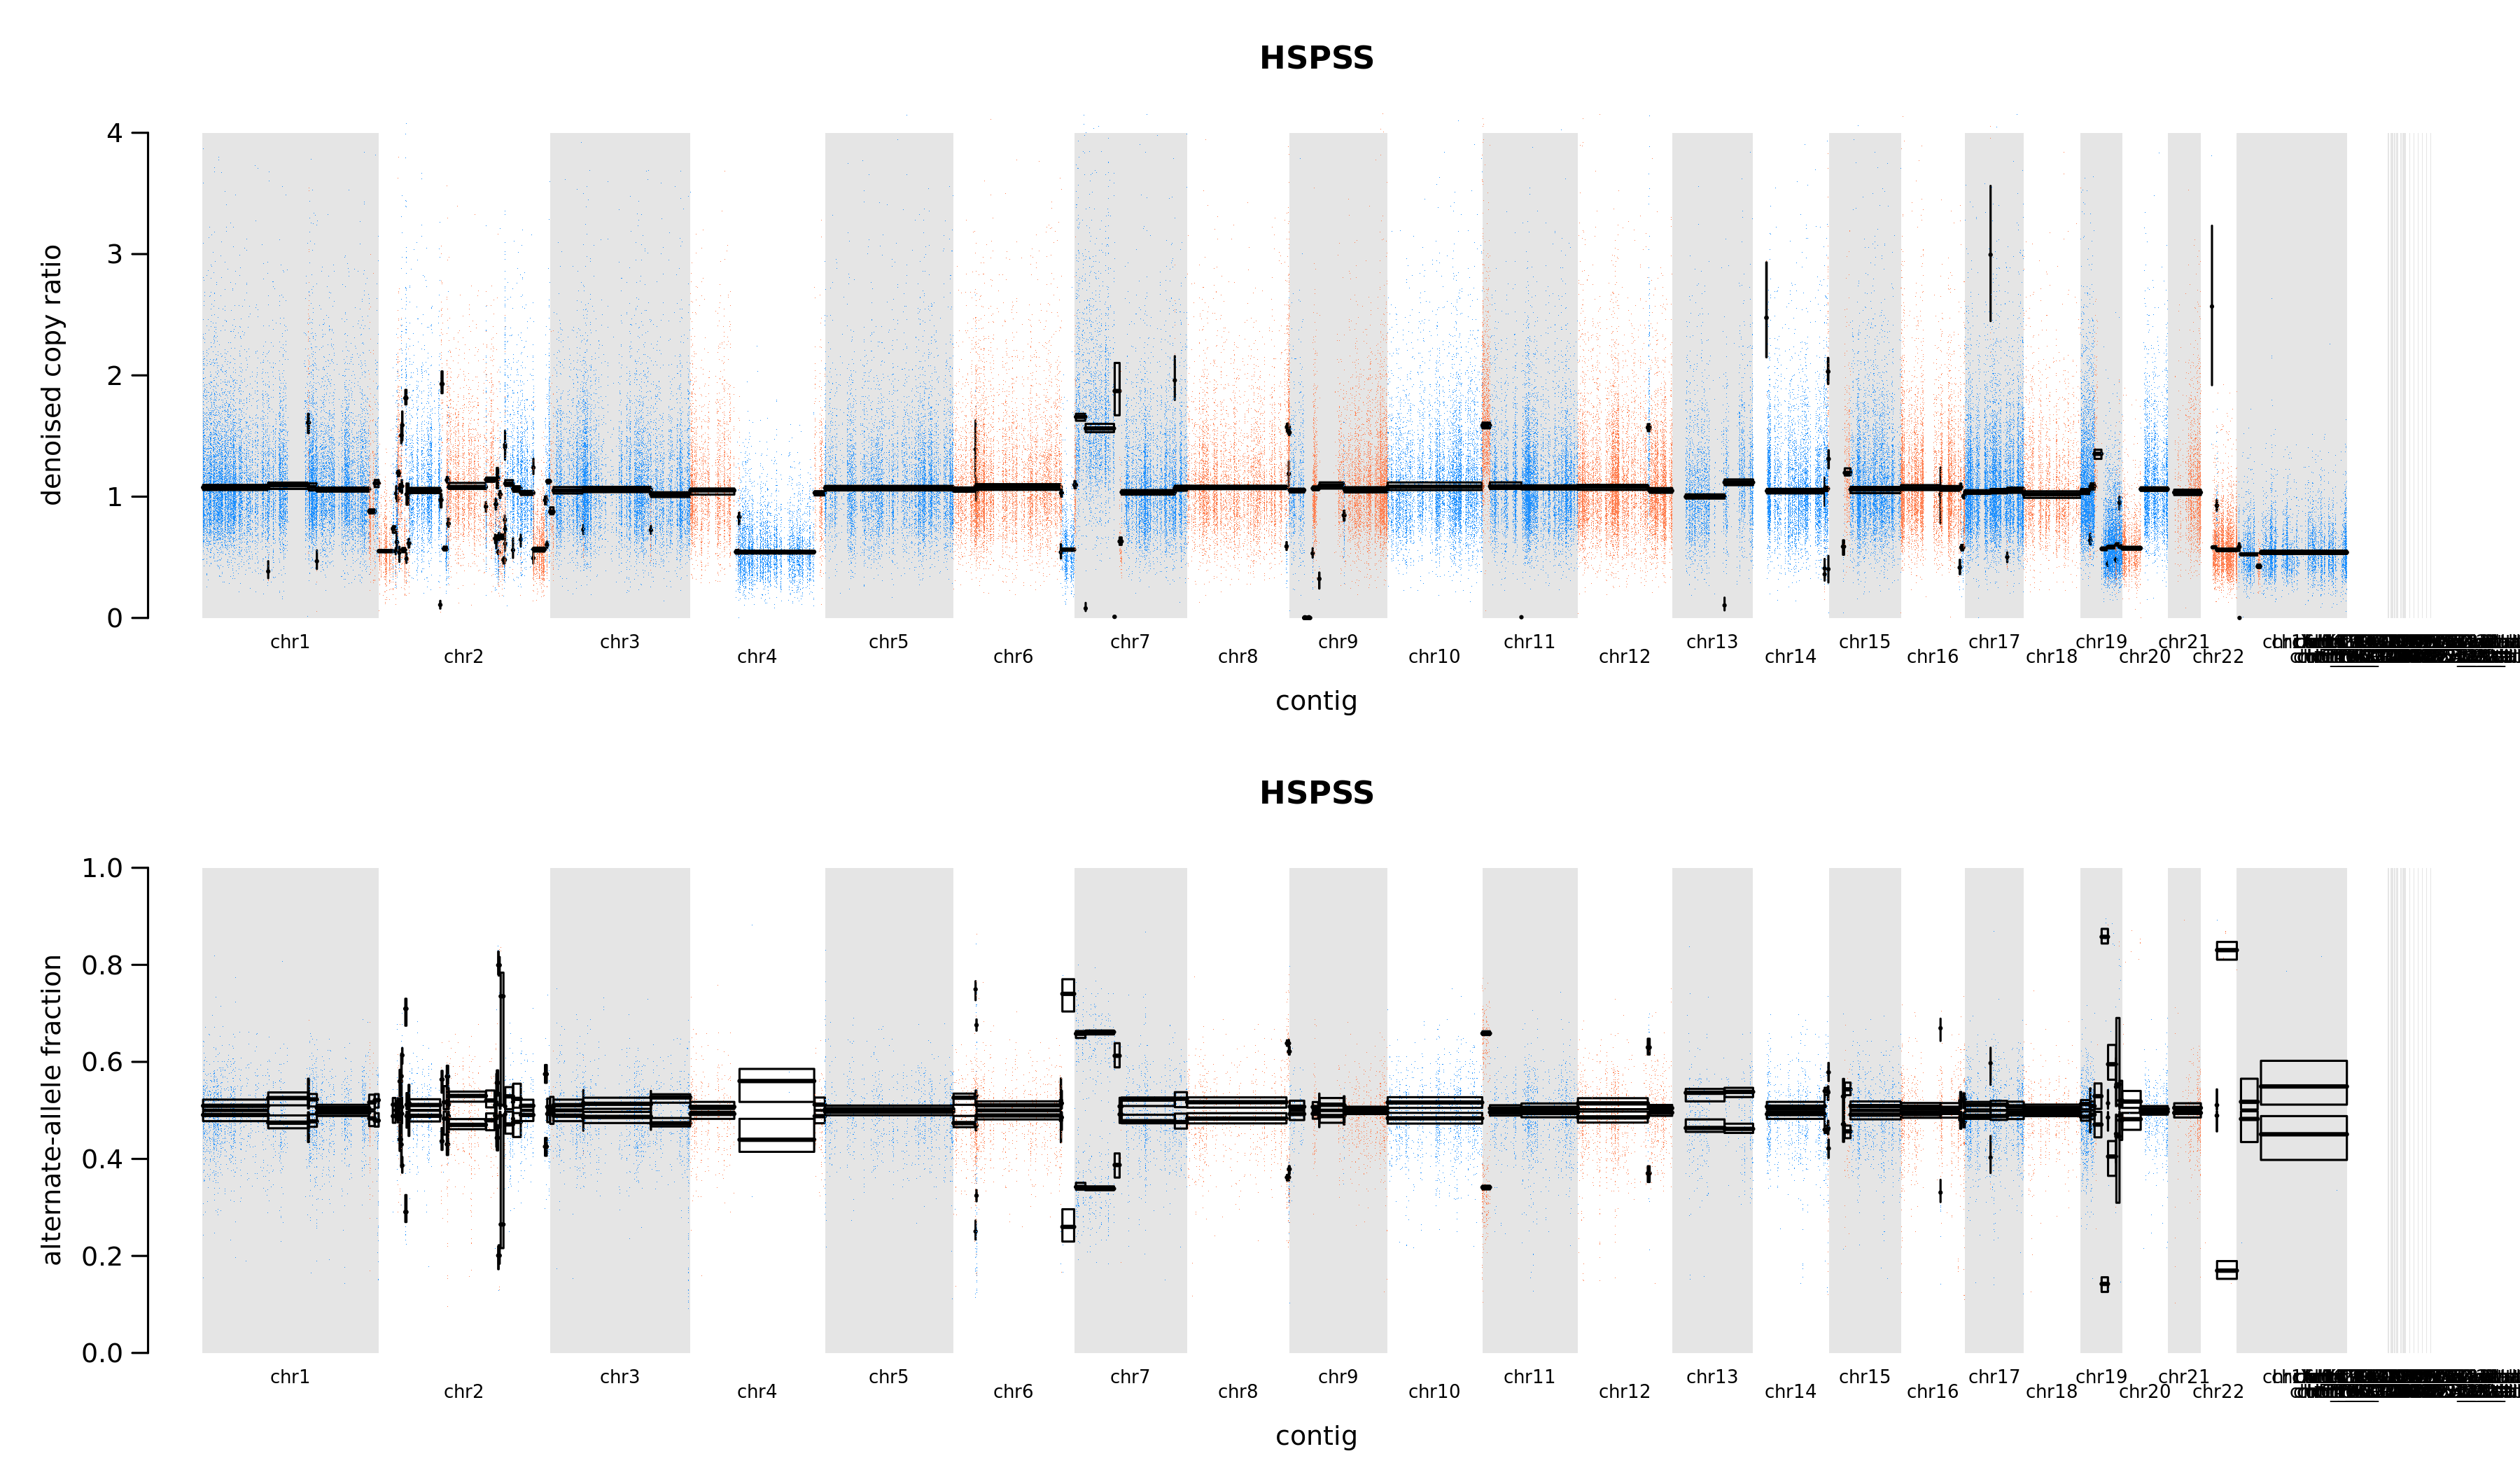

Copying gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/607fabda-c8f6-4e12-a48a-c131948074e1/CNVSomaticPairWorkflow/73bdc932-a83e-4b37-b0c9-d83c15995d99/call-PlotModeledSegmentsTumor/out/ACH-003000_1.hg38.modeled.png...
/ [1 files][588.9 KiB/588.9 KiB]                                                
Operation completed over 1 objects/588.9 KiB.                                    
ACH-003000_1


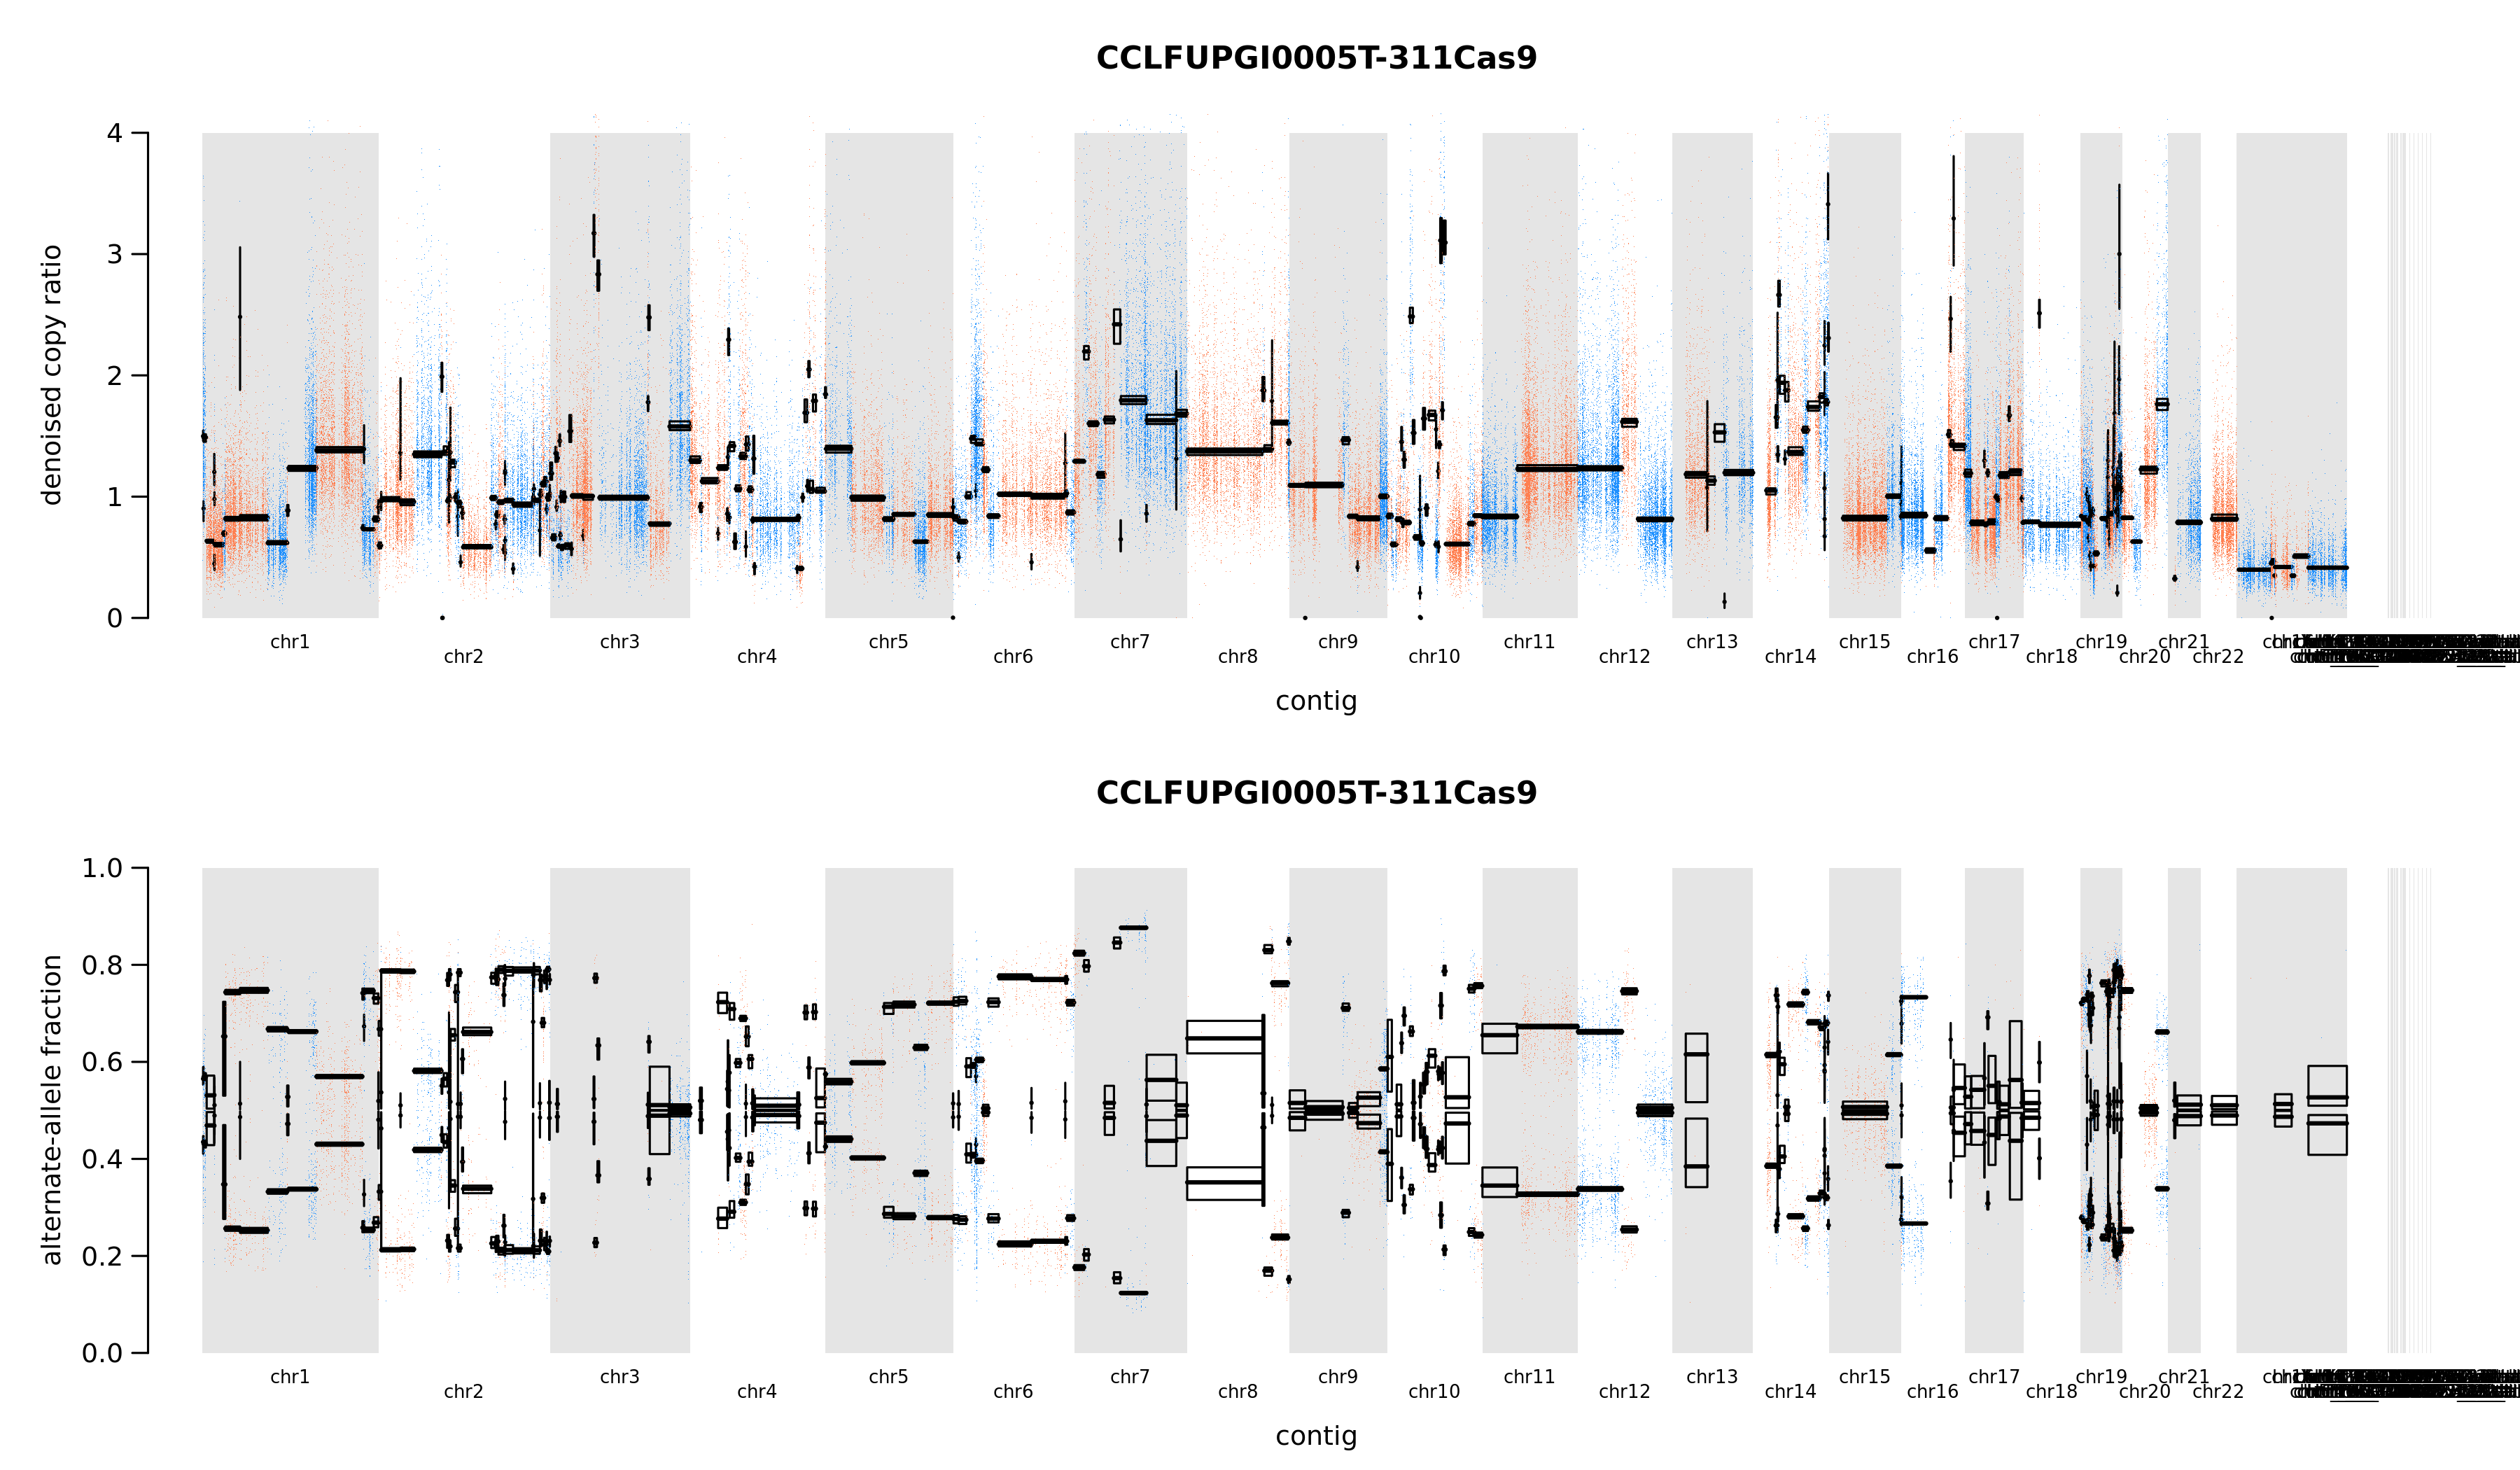

In [60]:
for k, val in samplesinset.iterrows():
    plot = val["modeled_segments_plot_tumor"]
    ! gsutil cp $plot temp/
    print(k)
    display(Image('temp/'+plot.split('/')[-1]))

These looks bad : 
M140325
OCIP5X

In [36]:
gsheets = sheets.get(sheeturl).sheets[6].to_frame()
wes_dmc_embargo = [i for i in gsheets['WES_DMC_embargo'].values.tolist() if i is not np.nan]
blacklist = [i for i in gsheets['blacklist'].values.tolist() if i is not np.nan]

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handlin

# Upload to taiga

- we load the blacklisted/embargoed sample ids
- we log2 transform and create a file for each release (and one containing everything)
- we upload the files using taigapy in a corresponding taiga dataset with the corresponding description and also upload it to its virtual dataset

## we push full dataset version in depmap taiga CN

In [67]:
print(segmentcn.Segment_Mean.max(), segmentcn.Segment_Mean.mean(), segmentcn.Segment_Mean.min())
print(genecn.values.max(), genecn.values.mean(),genecn.values.min())

7.220474335775503 0.9290886982666148 2.7805133399398313e-10
7.220474335775503 1.0049880669167381 2.7805133399398313e-10


In [66]:
## for genecn removing first blacklisted, then embargoed, to create two datasets
genecn = genecn.apply(lambda x: np.log2(1+x))
# WE DO NOT LOG2 TRANSFORM SEGMENTED

In [28]:
genecn.to_csv('temp/wes.'+release+'.gene.cn')
segmentcn.to_csv('temp/wes.'+release+'.segmented.cn', index=False) #NEED TO REMOVE INDEX

In [10]:
# OPTIONAL
wes_20Q1_gene = tc.get(name='segmented-cn-wes-prioritzed-7fe1', version=39, file='wes.20Q1.gene')
wes_20Q1_segmented = tc.get(name='segmented-cn-wes-prioritzed-7fe1', version=39, file='wes.20Q1.segmented')

[##################]100% |  12.9 MiB/s | 372.6 MiB / 372.6 MiB | Time:  0:00:28
[##################]100% |  54.1 MiB/s |  23.3 MiB /  23.3 MiB | Time:  0:00:00


In [29]:
tc.update_dataset(dataset_permaname="segmented-cn-wes-prioritzed-7fe1", 
                  upload_file_path_dict={
                    'temp/wes.'+release+'.gene.cn': 'NumericMatrixCSV',
                    'temp/wes.'+release+'.segmented.cn': 'TableCSV'},
                  dataset_description=
"""
# Copy Number

Combined segment and gene-level CN calls from Broad WES, Sanger WES, and Broad SNP. Relative CN, log2(x+1) transformed.

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

These data are generated for Achilles to pull from to run CERES.

Versions to use:

v25 for 19Q2 (hg38 aligned, Broad WES and Sanger WES based calls were generated from bam realignment. SNP based calls are still from liftover). The gene mapping script was updated to improve the gene level matrix (to remove NAs). The segmented level matrix is untransformed relative CN. Gene level matrix is log2(CN + 1).
v20 for 19Q1 (version 21 is hg19)
v18: for 18Q4
v15: for 18Q3
v11: for 18Q2
Gene-level matrix in versions below 10 were using hg38 and not hg19. Version 11 is corrected and should be used instead

Calls on X, Y chromosome for profiles should not be used.

Prioritization is as follows:

Broad WES kept over everything
Sanger WES kept if:
This cell line did not fail fingerprinting
This cell line has no other CN data
This cell lines does not have CRISPR LFC data from the Achilles screen
This CN profile correlates better with Achilles CRISPR LFC data than Broad SNP CN OR the % gene-level difference between this cell lines CN profile from Sanger WES and Broad SNP < 2.5%
Broad SNP used for remaining lines with no Broad WES or with Sanger WES that does not pass the criteria above
The 'Source' column indicates which CN profile was used for that cell line.

version 6: renamed Sample column to CCLE_name for consistency for the Achilles pipeline
version 7: missing chordoma lines
version 8: fixed to names of two chordoma lines (changed suffix from CHORDOMA -> BONE) and removed renamed cell lines that were duplicated (with different names). Reran comparison using 18q2 LFC results. Gene level matrix will be generated for version 9
version 11: corrected error in gene-level matrix calculation (previously had been aligned to hg38 however alignment should be hg19). Segment level calls are unaffected.
versions 12-14: Sanger WES were multiplied by 2 so should not be used
version 15: internal segments and gene level matrices for 18q3 release including public version (removed black list lines and Broad WES < 6 months old). Gene level matrices are indexed using Broad IDs.
version 16: internal segments and gene level matrices for 18q4 release including public version (uses all SNP and only WES if those lines are present in the 18Q4 public Achilles dataset)
version 17: same as version 16 but with two additional line in the internal version
version 18: same as version 17 but switched one line in public to use SNP instead of WES because not in public Avana
version 20: two major changes occurred (1) we are using a FireCloud based pipeline for CN calling now for Broad WES data (2) we have moved to use hg38. This is accomplished by lifting over coordinates from hg19 to hg38 after processed by the CN pipeline.
v21 same as version 20, but we are using the original hg19 coordinates, not hg38
version 25: Broad WES and Sanger WES were realigned to hg38. SNP still uses liftover from hg19 to hg38
version 35: Seeing what went wrong with the upload.
version 36: problem with not log2 transforming the data
version 37: resolving the problem with log2 transforming the segment data
version 38: resolving the problem with log2 transforming the segment data
version 39: 20Q1
version 40: unlog2 transforming segmentcn

Gene level CN data:

__Rows__: DepMap cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

Segmented data:

__Columns__: DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean""")

Uploading wes.20Q1.gene...
hitting https://cds.team/taiga/api/datafile/5353597eea6346dda3ad33529272969f
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in

'1f1a5ad7c7564905ac19cc3b1c8b7451'

## We push internal dataset with blacklisted removed

and we add it to eternal dataset and to virtual dataset

In [39]:
## for segment removing first blacklisted, then embargoed, to create two datasets
print(len(segmentcn))
segmentcn = segmentcn[~segmentcn.DepMap_ID.isin(blacklist)]
print(len(segmentcn))
segmentcn.to_csv('temp/internal_'+release+'_segs_cn', index=False)
print(len(genecn))
genecn = genecn[~genecn.index.isin(blacklist)]
print(len(genecn))
genecn.to_csv('temp/internal_'+release+'_gene_cn')

339401
339401
1760
1760


In [40]:
tc.update_dataset(dataset_permaname="depmap-wes-cn-data-81a7", 
                  upload_file_path_dict={
                    'temp/internal_'+release+'_gene_cn': 'NumericMatrixCSV',
                    'temp/internal_'+release+'_segs_cn': 'TableCSV'},
                  dataset_description=
"""
# Copy Number


## ** Version 1 Internal 18Q1****

Generated with the following script:

```
wes_pri <- taigr::load.from.taiga(data.name='gene-level-cn-87aa', 
                                  data.version=5, 
                                  data.file='gene_CN_WES_priority')
source_info <- data.frame(ccle_name=gsub("snp_|sangerWES_|ccleWES_|achillesWES_", 
                                         "", row.names(wes_pri)), 
                          source=gsub("_.*", "", row.names(wes_pri)))
wes_pri %<>% magrittr::set_rownames(source_info$ccle_name)

```

## ** Version 2 Internal 18Q2****

Generated with the following script:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=9, data.file='wes_priority_cn_gene_matrix') %>% log2()


```

## ** Version 3 Internal 18Q2****

Generated with the following script:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=11, data.file='wes_priority_cn_gene_matrix') %>% log2()


```
## ** Version 4-6 Internal 18Q3****

__Description__: log2 gene level copy number data

Generated with the following script:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=15, data.file='wes_priority_cn_gene_matrix') %>% log2()


```
__Rows__: Broad (arxspan) cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

Version 5 has updated cell line name mapping

Version 4 and 5 the segmented CN for Sanger's data is off by a factor of 2, version 6 corrects this

**** Version 7 Internal 18Q4****

__Description__: log2 gene level copy number data

Generated with the following script:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=17, data.file='wes_priority_cn_gene_matrix') %>% log2()


```
__Rows__: DepMap (arxspan) cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

## ** Version 8-9 Internal 19Q1****

version 9 has the correct data for 19Q1

## ** Version 10-11 Internal 19Q2****

__version 11 added an additional 13 cell lines and adds the segmented copy number data__

## ** Version 12 Internal 19Q3****

__Description__: log2(X + 1) gene level copy number data (data is now log2 transformed with a __pseudocount of 1__ added). CN data is generated using __hg38__. 


## ** Version 15 Internal 19Q4****

Adding 35 new cell lines

## ** Version 16 Internal 19Q4****
resolving problem with not having log2 transform 

## ** Version 17 Internal 19Q4****
resolving problem with having log2 transform on segments

## ** Version 18 Internal 20Q1****
adding 8 new cell lines

## ** Version 19 Internal 20Q1****
unlog2 transforming segmentcn


Some cells lines have been flagged as:

 - having bad looking copy ration plots = 
 - having too many segments = ACH-001079 2586, ACH-000044 1202, ACH-000258 872, ACH-001230 947, ACH-000068 812, ACH-000454 1051, ACH-000216 925, ACH-001150 782, ACH-001214 889, ACH-002335 1312, ACH-000836 1001, ACH-001957 1426, ACH-000960 913, ACH-000458 762, ACH-000578 869, ACH-000327 819, ACH-000090 1024, ACH-000488 954, ACH-000848 1171, ACH-000923 1469, ACH-000904 868, ACH-000452 816, ACH-000600 939, ACH-001656 902, ACH-000854 899, ACH-000774 953, ACH-001000 980, ACH-000941 813, ACH-000887 1408, ACH-001017 1223, ACH-001171 792, ACH-001071 1175, ACH-000593 764, ACH-001239 851, ACH-000071 1287, ACH-001956 1368, ACH-000509 873, ACH-002204 1318, ACH-000550 974, ACH-000738 1064, ACH-000870 1557, ACH-001036 858, ACH-001043 825, ACH-000028 868, ACH-001955 1296, ACH-000419 826, ACH-001234 819, ACH-001094 1036, ACH-001225 792, ACH-000118 794, ACH-000300 1431, ACH-001113 1072, ACH-001045 822, ACH-000444 974, ACH-000901 816, ACH-000865 1358, ACH-000961 763, ACH-001249 1756, ACH-000167 838, ACH-001101 1005, ACH-000842 929, ACH-000837 1015, ACH-000710 968, ACH-000195 2029, ACH-000064 1203, ACH-000690 771, ACH-000635 1368, ACH-000356 1294, ACH-000659 1129, ACH-000868 1422, ACH-000128 767, ACH-000658 927, ACH-001088 1337
 - Genes having a similar CN value accross all []

Gene level CN data:

__Rows__: DepMap cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

Segmented data:

__Columns__: DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean
""")

Uploading internal_20Q1_gene_cn...
hitting https://cds.team/taiga/api/datafile/1f5c72b449fe4cafa14bc228da211c83
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conve

'ca1c749740fa448f8da2cabda4ade239'

In [41]:
# To add to a virtual dataset
AddToVirtual(virtual_internal, 'depmap-wes-cn-data-81a7', [('CCLE_gene_cn', 'internal_'+release+'_gene_cn'),('CCLE_segment_cn', 'internal_'+release+'_segs_cn')])
# To add to a eternal dataset
AddToVirtual('depmap-a0ab', 'depmap-wes-cn-data-81a7', [('CCLE_gene_cn', 'internal_'+release+'_gene_cn'),('CCLE_segment_cn', 'internal_'+release+'_segs_cn')])

[('CCLE_gene_cn', 'depmap-wes-cn-data-81a7.19/internal_20Q1_gene_cn'), ('CCLE_segment_cn', 'depmap-wes-cn-data-81a7.19/internal_20Q1_segs_cn'), ('CCLE_expression', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_proteincoding_tpm'), ('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_counts'), ('CCLE_fusions_unfiltered', 'gene-fusions-8b7a.10/unfiltered_fusions_20Q1'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_transcripts_tpm'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-363a.22/internal_20Q1_tpm'), ('CCLE_fusions', 'gene-fusions-8b7a.10/filtered_fusions_20Q1')]
hitting https://cds.team/taiga/api/datafile/9175d8d4e7e64f0c84d11102426e3a75
hitting https://cds.team/taiga/api/datafile/9175d8d4e7e64f0c84d11102426e3a75
hitting https://cds.team/taiga/api/datafile/9175d8d4e7e64f0c84d11102426e3a75
hitting https://cds.team/taiga/api/datafile/9175d8d4e7e64f0c84d11102426e3a75
hitting https://cds.team/taiga/api/datafile

## We add to dmc as in internal

In [42]:
os.system('mv temp/internal_'+release+'_gene_cn temp/dmc_'+release+'_gene_cn')
os.system('mv temp/internal_'+release+'_segs_cn temp/dmc_'+release+'_segs_cn')

0

In [43]:
tc.update_dataset(dataset_permaname="depmap-cn-data-9b9d",
                upload_file_path_dict={
                    'temp/dmc_'+release+'_gene_cn':'NumericMatrixCSV',
                    'temp/dmc_'+release+'_segs_cn': 'TableCSV',
                   },
                
                  dataset_description="""
**** Version 1-2 DMC 19Q1****

version 2 contains the correct data for 19Q1

**** Version 3-4 DMC 19Q2****

__version 4 added an additional 13 cell lines and adds the segmented copy number data__

**** Version 5 DMC 19Q3***

**** Version 7 DMC 19Q4***
adding 35 new cell lines

**** Version 8 DMC 19Q4****
resolving problem with not having log2 transform 

**** Version 9 DMC 19Q4****
resolving problem with having log2 transformed the segments

**** Version 10 DMC 20Q1****
adding new samples

**** Version 11 DMC 20Q1****
unlog2 transforming segmentcn

__Description__: log2(X + 1) gene level copy number data (data is now log2 transformed with a __pseudocount of 1__ added). CN data is generated using __hg38__.  The segmented copy number data includes the mean segmented copy number segments.

Gene level CN data:

__Rows__: DepMap cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

Segmented data:

__Columns__: DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean
""")

Uploading dmc_20Q1_gene_cn...
hitting https://cds.team/taiga/api/datafile/7f805ae696284454ac621a28fb1614b4
Conversion and upload...:
	 Waiting in the task queue
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in pro

'ab5527f9240d49e88905e5b2b2f04d08'

In [44]:
AddToVirtual(virtual_dmc, "depmap-cn-data-9b9d", files=[('CCLE_gene_cn', 'dmc_'+release+'_gene_cn'),('CCLE_segment_cn', 'dmc_'+release+'_segs_cn')])

[('CCLE_gene_cn', 'depmap-cn-data-9b9d.11/dmc_20Q1_gene_cn'), ('CCLE_segment_cn', 'depmap-cn-data-9b9d.11/dmc_20Q1_segs_cn'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_tpm'), ('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_counts'), ('CCLE_expression', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_proteincoding_tpm'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-80ef.10/dmc_20Q1_transcripts_tpm'), ('CCLE_fusions_unfiltered', 'gene-fusions-375f.6/unfiltered_fusions_20Q1'), ('CCLE_fusions', 'gene-fusions-375f.6/filtered_fusions_20Q1')]
hitting https://cds.team/taiga/api/datafile/4146cfe8d3834dd6a9bd5d500032b04f
hitting https://cds.team/taiga/api/datafile/4146cfe8d3834dd6a9bd5d500032b04f
hitting https://cds.team/taiga/api/datafile/4146cfe8d3834dd6a9bd5d500032b04f
hitting https://cds.team/taiga/api/datafile/4146cfe8d3834dd6a9bd5d500032b04f
hitting https://cds.team/taiga/api/datafile/4146cfe8d3834dd6a9bd5d500032b04f
hittin

## We add to public as internal minus dmc embargoed and only cell lines from previous previous release (6 month)

In [47]:
print(len(segmentcn))
segmentcn = segmentcn[segmentcn.DepMap_ID.isin(prevprev)]
segmentcn = segmentcn[~segmentcn.DepMap_ID.isin(set(wes_dmc_embargo))]
print(len(segmentcn))
segmentcn.to_csv('temp/public_' + release + '_segs_cn', index=False)
print(len(genecn))
genecn = genecn[genecn.index.isin(prevprev)]
genecn = genecn[~genecn.index.isin(set(wes_dmc_embargo))]
print(len(genecn))
genecn.to_csv('temp/public_'+release+'_gene_cn')

339401
331272
1760
1713


In [48]:
tc.update_dataset(dataset_permaname='depmap-wes-cn-data-97cc',
                    upload_file_path_dict={
                    'temp/public_'+release+'_gene_cn':'NumericMatrixCSV',
                    'temp/public_'+release+'_segs_cn': 'TableCSV',
                   },
                  dataset_description="""
**** Versions 1-5 Public 18Q1****

Gene-level WES copy-number data for publicly accessible CCLE data. 

```

internal_lines <- readr::read_csv("~/Downloads/avana-broad-18q1_v2-sample-info.csv")$cell_line
public_lines <- readr::read_csv("~/Downloads/avana-public-tentative-18q1_v5-sample-info.csv")$cell_line
non_public_lines <- setdiff(internal_lines, public_lines)

full_cn_set <- taigr::load.from.taiga(data.name='gene-level-cn-87aa', data.version=5, data.file='full_gene_CN')
source_info <- data.frame(source=gsub("_.*", "", row.names(full_cn_set)),
                          ccle_name=gsub("snp_|achillesWES_|ccleWES_|sangerWES_", "",
                                         row.names(full_cn_set)),
                          row_idx=1:nrow(full_cn_set))
to_remove <- source_info %>%
  dplyr::filter(ccle_name %in% non_public_lines,
                source %in% c("ccleWES", "achillesWES"))
also_to_remove <- source_info %>%
                    dplyr::filter(source == "sangerWES")
indices_to_remove <- c(to_remove$row_idx, also_to_remove$row_idx) %>% unique()
indices_to_keep <- source_info %>%
  dplyr::filter(!(row_idx %in% indices_to_remove)) %>%
  dplyr::group_by(ccle_name) %>%
  dplyr::mutate(priority=ifelse(source == "snp", 4,
                                ifelse(source == "sangerWES", 3,
                                       ifelse(source == "ccleWES", 2, 1)))) %>%
  dplyr::filter(priority == min(priority)) %>%
  dplyr::ungroup()

public_cn <- full_cn_set[indices_to_keep$row_idx,]
source_info <- data.frame(source=gsub("_.*", "", row.names(public_cn)),
                          ccle_name=gsub("snp_|achillesWES_|ccleWES_|sangerWES_", "",
                                         row.names(public_cn)))
public_cn %<>% magrittr::set_rownames(source_info$ccle_name)
```

CN data are on a log2 scale.

`WES_source_info` tracks the source data for each cell line. Sources are `snp`, `achillesWES`, `ccleWES`, and `sangerWES`

NOTE: Version 1 contained WES data from cell lines not available in the 18Q1 Public release. Versions 2-4 contained Sanger's WES CN data

**** Version 6 Public 18Q2****

Generated by running:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=10, data.file='public_wes_priority_cn_gene_matrix') %>% log2()
```

**** Version 7 Public 18Q2****

Generated by running:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=11, data.file='public_wes_priority_cn_gene_matrix') %>% log2()
```


**** Version 8-9 Public 18Q3****

Generated by running:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=15, data.file='public_wes_priority_cn_gene_matrix') %>% log2()
```
Version 8 the segmented CN for Sanger's data is off by a factor of 2, version 9 corrects this

includes cell lines that should not be public

**** Version 10 Public 18Q1, 18Q2, 18Q3****

__use version 10 for 18Q1, 18Q2 and 18Q3 datasets__ 

Version 10 is the most up-to-date version of "public\_18Q3\_gene\_cn.csv". The three datasets have been updated to remove cell lines that should not have been made public. They are named in the portal and google bucket for portal downloads as v2, e.g. public\_18Q3\_gene\_cn\_v2.csv.

__Rows__: Broad (arxspan) cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

**** Version 11 Public 18Q4****

Generated by running:

```
wes_pri <- taigr::load.from.taiga(data.name='segmented-cn-wes-prioritzed-7fe1', data.version=17, data.file='public_wes_priority_cn_gene_matrix') %>% log2()
```

__Rows__: DepMap (arxspan) cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

**** Version 12-14 Public 19Q1****

version 14 contains the correct data for 19Q1

version 13 is the same as v12 except that it uses the original hg19 coordinates not hg38. The Achilles public data set uses the hg19 coordinates. 

**** Version 15-16 Public 19Q2****

__version 16 also adds the segmented copy number data__

**** Version 17-18 Public 19Q3****

__data is hg38 liftover__

__Description__: log2 + 1 gene level copy number data (data is log2 transformed with a __pseudocount of 1__ added). It uses hg19 coordinates. Also the segmented copy number data.

**** Version 23 Public 19Q4****

adding new cell lines

**** Version 24 Internal 19Q4****
resolving problem with not having log2 transform 

**** Version 25 Internal 20Q1****
adding new samples

**** Version 26 Internal 20Q1****
unlog2 transforming segmentcn

## Gene level CN data:

__Rows__: DepMap cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

Segmented data:

__Columns__: DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean, CCLE\_name
""")

Uploading public_20Q1_gene_cn...
hitting https://cds.team/taiga/api/datafile/9b72773bf6114f8caf6ff78bd33e3ea5
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, li

'9705a741b7964d57a1835c5336920569'

In [49]:
# To add to a virtual dataset
AddToVirtual(virtual_public, "depmap-wes-cn-data-97cc", files=[('CCLE_gene_cn', 'public_'+release+'_gene_cn'),('CCLE_segment_cn', 'public_'+release+'_segs_cn')])

[('CCLE_gene_cn', 'depmap-wes-cn-data-97cc.29/public_20Q1_gene_cn'), ('CCLE_segment_cn', 'depmap-wes-cn-data-97cc.29/public_20Q1_segs_cn'), ('CCLE_fusions', 'gene-fusions-6212.9/filtered_fusions_20Q1'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_tpm'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_transcripts_tpm'), ('CCLE_fusions_unfiltered', 'gene-fusions-6212.9/unfiltered_fusions_20Q1'), ('CCLE_expression', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_proteincoding_tpm'), ('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-ccd0.18/public_20Q1_counts')]
hitting https://cds.team/taiga/api/datafile/36677723f8044f86ac7150294672c8bd
hitting https://cds.team/taiga/api/datafile/36677723f8044f86ac7150294672c8bd
hitting https://cds.team/taiga/api/datafile/36677723f8044f86ac7150294672c8bd
hitting https://cds.team/taiga/api/datafile/36677723f8044f86ac7150294672c8bd
hitting https://cds.team/taiga/api/datafile/36677723f8044